# Music Video Genre Classification using Deep Learning

### Team Members
**Aditya Soni  
Aritra Chowdhury  
Chandler Wann  
Rhiannon Pytlak  
Yen Wen Ting**

## Dataset

The dataset is used and stored in a folder named Video Files. The dataset can be downloaded [here](https://drive.google.com/drive/u/0/folders/0AIVtKo7r0hTqUk9PVA). 

## Methodology

Two approaches are used. 
- Classification using CNN-RNN on Image Frames ([Reference Link](https://keras.io/examples/vision/video_classification/))
- Classification after combining Image with Audio features ([Reference Link](https://francescopochetti.com/video-classification-experiments-combining-image-with-audio-features/))

In [1]:
import sys
import os
import pickle
import random 
import operator
import math
import numpy as np
import pandas as pd
from collections import defaultdict
import sunau
import librosa
import librosa.display
import IPython.display as ipd
from IPython.display import HTML
import matplotlib.pyplot as plt
import imageio
import cv2
import subprocess
import io
import pickle
import base64
import imageio
import itertools

import scipy
from python_speech_features import mfcc
import scipy.io.wavfile as wav
from tempfile import TemporaryFile
from imutils import paths
from pathlib import Path
import librosa
import librosa.display
import joblib
from PIL import Image
from numpy import asarray
from pydub import AudioSegment

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score
from sklearn.datasets import make_multilabel_classification
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn import svm
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression

import tensorflow
from tensorflow import keras
from tensorflow_docs.vis import embed
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from keras.models import Model
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator, array_to_img
from keras.applications.vgg16 import VGG16
from keras.layers import GlobalAveragePooling2D

import warnings
warnings.filterwarnings("ignore")

%load_ext autoreload
%autoreload 2
%matplotlib inline

## Part 1: Classification using CNN-RNN on Image Frames

Two different labels are used for classification. 
- Genres
- Emotions

In [2]:
IMG_SIZE = 224
BATCH_SIZE = 64
EPOCHS = 500

MAX_SEQ_LENGTH = 20
NUM_FEATURES = 2048

### Feature Extraction

#### Genres

In [3]:
def crop_center_square(frame):
    y, x = frame.shape[0:2]
    min_dim = min(y, x)
    start_x = (x // 2) - (min_dim // 2)
    start_y = (y // 2) - (min_dim // 2)
    return frame[start_y : start_y + min_dim, start_x : start_x + min_dim]

def load_video(path, max_frames=0, resize=(IMG_SIZE, IMG_SIZE)):
    cap = cv2.VideoCapture(path)
    frames = []
    try:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            frame = crop_center_square(frame)
            frame = cv2.resize(frame, resize)
            frame = frame[:, :, [2, 1, 0]]
            frames.append(frame)

            if len(frames) == max_frames:
                break
    finally:
        cap.release()
    return np.array(frames)

def build_feature_extractor():
    feature_extractor = keras.applications.InceptionV3(
        weights="imagenet",
        include_top=False,
        pooling="avg",
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
    )
    preprocess_input = keras.applications.inception_v3.preprocess_input

    inputs = keras.Input((IMG_SIZE, IMG_SIZE, 3))
    preprocessed = preprocess_input(inputs)

    outputs = feature_extractor(preprocessed)
    return keras.Model(inputs, outputs, name="feature_extractor")


feature_extractor = build_feature_extractor()

In [4]:
df = pd.read_csv('Video Labels.csv')

train_df = df[df['train or test'] == 'train'][['video_name', 'tag']]
test_df = df[df['train or test'] == 'test'][['video_name', 'tag']]

root = os.path.join(os.getcwd(), 'Video Files')

label_processor = keras.layers.StringLookup(
    num_oov_indices=0, vocabulary=np.unique(train_df['tag'])
)

In [5]:
def prepare_all_videos(df, root_dir):
    num_samples = len(df)
    print(num_samples)
    video_paths = df["video_name"].values.tolist()
    labels = df["tag"].values
    labels = label_processor(labels[..., None]).numpy()

    # `frame_masks` and `frame_features` are what we will feed to our sequence model.
    # `frame_masks` will contain a bunch of booleans denoting if a timestep is
    # masked with padding or not.
    frame_masks = np.zeros(shape=(num_samples, MAX_SEQ_LENGTH), dtype="bool")
    frame_features = np.zeros(
        shape=(num_samples, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
    )
    flag = 1
    # For each video.
    for idx, path in enumerate(video_paths):
        # Gather all its frames and add a batch dimension.
        frames = load_video(os.path.join(root_dir, path))
        frames = frames[None, ...]
        print('Processing Video:', flag)
        flag = flag + 1
        # Initialize placeholders to store the masks and features of the current video.
        temp_frame_mask = np.zeros(shape=(1, MAX_SEQ_LENGTH,), dtype="bool")
        temp_frame_features = np.zeros(
            shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
        )

        # Extract features from the frames of the current video.
        for i, batch in enumerate(frames):
            video_length = batch.shape[0]
            length = min(MAX_SEQ_LENGTH, video_length)
            for j in range(length):
                temp_frame_features[i, j, :] = feature_extractor.predict(
                    batch[None, j, :]
                )
            temp_frame_mask[i, :length] = 1  # 1 = not masked, 0 = masked

        frame_features[idx,] = temp_frame_features.squeeze()
        frame_masks[idx,] = temp_frame_mask.squeeze()

    return (frame_features, frame_masks), labels

In [6]:
print('Processing Training Data\n')
train_data, train_labels = prepare_all_videos(train_df, root)
print('\nProcessing Test Data\n')
test_data, test_labels = prepare_all_videos(test_df, root)

Processing Training Data

1006
Processing Video: 1
Processing Video: 2
Processing Video: 3
Processing Video: 4
Processing Video: 5
Processing Video: 6
Processing Video: 7
Processing Video: 8
Processing Video: 9
Processing Video: 10
Processing Video: 11
Processing Video: 12
Processing Video: 13
Processing Video: 14
Processing Video: 15
Processing Video: 16
Processing Video: 17
Processing Video: 18
Processing Video: 19
Processing Video: 20
Processing Video: 21
Processing Video: 22
Processing Video: 23
Processing Video: 24
Processing Video: 25
Processing Video: 26
Processing Video: 27
Processing Video: 28
Processing Video: 29
Processing Video: 30
Processing Video: 31
Processing Video: 32
Processing Video: 33
Processing Video: 34
Processing Video: 35
Processing Video: 36
Processing Video: 37
Processing Video: 38
Processing Video: 39
Processing Video: 40
Processing Video: 41
Processing Video: 42
Processing Video: 43
Processing Video: 44
Processing Video: 45
Processing Video: 46
Processing V

Processing Video: 377
Processing Video: 378
Processing Video: 379
Processing Video: 380
Processing Video: 381
Processing Video: 382
Processing Video: 383
Processing Video: 384
Processing Video: 385
Processing Video: 386
Processing Video: 387
Processing Video: 388
Processing Video: 389
Processing Video: 390
Processing Video: 391
Processing Video: 392
Processing Video: 393
Processing Video: 394
Processing Video: 395
Processing Video: 396
Processing Video: 397
Processing Video: 398
Processing Video: 399
Processing Video: 400
Processing Video: 401
Processing Video: 402
Processing Video: 403
Processing Video: 404
Processing Video: 405
Processing Video: 406
Processing Video: 407
Processing Video: 408
Processing Video: 409
Processing Video: 410
Processing Video: 411
Processing Video: 412
Processing Video: 413
Processing Video: 414
Processing Video: 415
Processing Video: 416
Processing Video: 417
Processing Video: 418
Processing Video: 419
Processing Video: 420
Processing Video: 421
Processing

Processing Video: 750
Processing Video: 751
Processing Video: 752
Processing Video: 753
Processing Video: 754
Processing Video: 755
Processing Video: 756
Processing Video: 757
Processing Video: 758
Processing Video: 759
Processing Video: 760
Processing Video: 761
Processing Video: 762
Processing Video: 763
Processing Video: 764
Processing Video: 765
Processing Video: 766
Processing Video: 767
Processing Video: 768
Processing Video: 769
Processing Video: 770
Processing Video: 771
Processing Video: 772
Processing Video: 773
Processing Video: 774
Processing Video: 775
Processing Video: 776
Processing Video: 777
Processing Video: 778
Processing Video: 779
Processing Video: 780
Processing Video: 781
Processing Video: 782
Processing Video: 783
Processing Video: 784
Processing Video: 785
Processing Video: 786
Processing Video: 787
Processing Video: 788
Processing Video: 789
Processing Video: 790
Processing Video: 791
Processing Video: 792
Processing Video: 793
Processing Video: 794
Processing

Processing Video: 120
Processing Video: 121
Processing Video: 122
Processing Video: 123
Processing Video: 124
Processing Video: 125
Processing Video: 126
Processing Video: 127
Processing Video: 128
Processing Video: 129
Processing Video: 130
Processing Video: 131
Processing Video: 132
Processing Video: 133
Processing Video: 134
Processing Video: 135
Processing Video: 136
Processing Video: 137
Processing Video: 138
Processing Video: 139
Processing Video: 140
Processing Video: 141
Processing Video: 142
Processing Video: 143
Processing Video: 144
Processing Video: 145
Processing Video: 146
Processing Video: 147
Processing Video: 148
Processing Video: 149
Processing Video: 150
Processing Video: 151
Processing Video: 152
Processing Video: 153
Processing Video: 154
Processing Video: 155
Processing Video: 156
Processing Video: 157
Processing Video: 158
Processing Video: 159
Processing Video: 160
Processing Video: 161
Processing Video: 162
Processing Video: 163
Processing Video: 164
Processing

#### Emotions

In [7]:
train_df_emo = df[df['train or test'] == 'train'][['video_name', 'emotion_label']]
test_df_emo = df[df['train or test'] == 'test'][['video_name', 'emotion_label']]

train_df_emo.columns = ['video_name', 'tag']
test_df_emo.columns = ['video_name', 'tag']

label_processor_emo = keras.layers.StringLookup(
    num_oov_indices=0, vocabulary=np.unique(train_df_emo['tag'])
)

In [8]:
def prepare_all_videos_emo(df, root_dir):
    num_samples = len(df)
    print(num_samples)
    video_paths = df["video_name"].values.tolist()
    labels = df["tag"].values
    labels = label_processor_emo(labels[..., None]).numpy()

    # `frame_masks` and `frame_features` are what we will feed to our sequence model.
    # `frame_masks` will contain a bunch of booleans denoting if a timestep is
    # masked with padding or not.
    frame_masks = np.zeros(shape=(num_samples, MAX_SEQ_LENGTH), dtype="bool")
    frame_features = np.zeros(
        shape=(num_samples, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
    )
    flag = 1
    # For each video.
    for idx, path in enumerate(video_paths):
        # Gather all its frames and add a batch dimension.
        frames = load_video(os.path.join(root_dir, path))
        frames = frames[None, ...]
        print('Processing Video:', flag)
        flag = flag + 1
        # Initialize placeholders to store the masks and features of the current video.
        temp_frame_mask = np.zeros(shape=(1, MAX_SEQ_LENGTH,), dtype="bool")
        temp_frame_features = np.zeros(
            shape=(1, MAX_SEQ_LENGTH, NUM_FEATURES), dtype="float32"
        )

        # Extract features from the frames of the current video.
        for i, batch in enumerate(frames):
            video_length = batch.shape[0]
            length = min(MAX_SEQ_LENGTH, video_length)
            for j in range(length):
                temp_frame_features[i, j, :] = feature_extractor.predict(
                    batch[None, j, :]
                )
            temp_frame_mask[i, :length] = 1  # 1 = not masked, 0 = masked

        frame_features[idx,] = temp_frame_features.squeeze()
        frame_masks[idx,] = temp_frame_mask.squeeze()

    return (frame_features, frame_masks), labels

In [9]:
train_data_emo, train_labels_emo = prepare_all_videos_emo(train_df_emo, root)
test_data_emo, test_labels_emo = prepare_all_videos_emo(test_df_emo, root)

1006
Processing Video: 1
Processing Video: 2
Processing Video: 3
Processing Video: 4
Processing Video: 5
Processing Video: 6
Processing Video: 7
Processing Video: 8
Processing Video: 9
Processing Video: 10
Processing Video: 11
Processing Video: 12
Processing Video: 13
Processing Video: 14
Processing Video: 15
Processing Video: 16
Processing Video: 17
Processing Video: 18
Processing Video: 19
Processing Video: 20
Processing Video: 21
Processing Video: 22
Processing Video: 23
Processing Video: 24
Processing Video: 25
Processing Video: 26
Processing Video: 27
Processing Video: 28
Processing Video: 29
Processing Video: 30
Processing Video: 31
Processing Video: 32
Processing Video: 33
Processing Video: 34
Processing Video: 35
Processing Video: 36
Processing Video: 37
Processing Video: 38
Processing Video: 39
Processing Video: 40
Processing Video: 41
Processing Video: 42
Processing Video: 43
Processing Video: 44
Processing Video: 45
Processing Video: 46
Processing Video: 47
Processing Video:

Processing Video: 379
Processing Video: 380
Processing Video: 381
Processing Video: 382
Processing Video: 383
Processing Video: 384
Processing Video: 385
Processing Video: 386
Processing Video: 387
Processing Video: 388
Processing Video: 389
Processing Video: 390
Processing Video: 391
Processing Video: 392
Processing Video: 393
Processing Video: 394
Processing Video: 395
Processing Video: 396
Processing Video: 397
Processing Video: 398
Processing Video: 399
Processing Video: 400
Processing Video: 401
Processing Video: 402
Processing Video: 403
Processing Video: 404
Processing Video: 405
Processing Video: 406
Processing Video: 407
Processing Video: 408
Processing Video: 409
Processing Video: 410
Processing Video: 411
Processing Video: 412
Processing Video: 413
Processing Video: 414
Processing Video: 415
Processing Video: 416
Processing Video: 417
Processing Video: 418
Processing Video: 419
Processing Video: 420
Processing Video: 421
Processing Video: 422
Processing Video: 423
Processing

Processing Video: 752
Processing Video: 753
Processing Video: 754
Processing Video: 755
Processing Video: 756
Processing Video: 757
Processing Video: 758
Processing Video: 759
Processing Video: 760
Processing Video: 761
Processing Video: 762
Processing Video: 763
Processing Video: 764
Processing Video: 765
Processing Video: 766
Processing Video: 767
Processing Video: 768
Processing Video: 769
Processing Video: 770
Processing Video: 771
Processing Video: 772
Processing Video: 773
Processing Video: 774
Processing Video: 775
Processing Video: 776
Processing Video: 777
Processing Video: 778
Processing Video: 779
Processing Video: 780
Processing Video: 781
Processing Video: 782
Processing Video: 783
Processing Video: 784
Processing Video: 785
Processing Video: 786
Processing Video: 787
Processing Video: 788
Processing Video: 789
Processing Video: 790
Processing Video: 791
Processing Video: 792
Processing Video: 793
Processing Video: 794
Processing Video: 795
Processing Video: 796
Processing

Processing Video: 123
Processing Video: 124
Processing Video: 125
Processing Video: 126
Processing Video: 127
Processing Video: 128
Processing Video: 129
Processing Video: 130
Processing Video: 131
Processing Video: 132
Processing Video: 133
Processing Video: 134
Processing Video: 135
Processing Video: 136
Processing Video: 137
Processing Video: 138
Processing Video: 139
Processing Video: 140
Processing Video: 141
Processing Video: 142
Processing Video: 143
Processing Video: 144
Processing Video: 145
Processing Video: 146
Processing Video: 147
Processing Video: 148
Processing Video: 149
Processing Video: 150
Processing Video: 151
Processing Video: 152
Processing Video: 153
Processing Video: 154
Processing Video: 155
Processing Video: 156
Processing Video: 157
Processing Video: 158
Processing Video: 159
Processing Video: 160
Processing Video: 161
Processing Video: 162
Processing Video: 163
Processing Video: 164
Processing Video: 165
Processing Video: 166
Processing Video: 167
Processing

### Classification

#### Genres

In [10]:
# Utility for our sequence model.
def get_sequence_model():
    class_vocab = label_processor.get_vocabulary()

    frame_features_input = keras.Input((MAX_SEQ_LENGTH, NUM_FEATURES))
    mask_input = keras.Input((MAX_SEQ_LENGTH,), dtype="bool")

    # Refer to the following tutorial to understand the significance of using `mask`:
    # https://keras.io/api/layers/recurrent_layers/gru/
    optimizer = keras.optimizers.Adam(learning_rate=0.00001)
    x = keras.layers.GRU(16, return_sequences=True)(
        frame_features_input, mask=mask_input
    )
    x = keras.layers.GRU(8)(x)
    x = keras.layers.Dropout(0.4)(x)
    x = keras.layers.Dense(8, activation="relu")(x)
    output = keras.layers.Dense(len(class_vocab), activation="softmax")(x)

    rnn_model = keras.Model([frame_features_input, mask_input], output)

    rnn_model.compile(
        loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"]
    )
    return rnn_model


# Utility for running experiments.
def run_experiment():
    filepath = os.path.join(os.getcwd(), 'tmp', 'video_classifier')
    checkpoint = keras.callbacks.ModelCheckpoint(
        filepath, save_weights_only=True, save_best_only=True, verbose=1
    )

    seq_model = get_sequence_model()
    history = seq_model.fit(
        [train_data[0], train_data[1]],
        train_labels,
        validation_split=0.3,
        epochs=EPOCHS,
        callbacks=[checkpoint],
    )

    seq_model.load_weights(filepath)
    _, accuracy = seq_model.evaluate([test_data[0], test_data[1]], test_labels)
    
    return history, seq_model


hist, sequence_model = run_experiment()

Epoch 1/500
21/22 [===========================>..] - ETA: 0s - loss: 2.3901 - accuracy: 0.0670
Epoch 00001: val_loss improved from inf to 2.29866, saving model to C:\Users\aritr\Documents\Project\tmp\video_classifier
22/22 [==============================] - 6s 105ms/step - loss: 2.3893 - accuracy: 0.0668 - val_loss: 2.2987 - val_accuracy: 0.1291
Epoch 2/500
20/22 [==========================>...] - ETA: 0s - loss: 2.3728 - accuracy: 0.0656
Epoch 00002: val_loss improved from 2.29866 to 2.29793, saving model to C:\Users\aritr\Documents\Project\tmp\video_classifier
22/22 [==============================] - 0s 22ms/step - loss: 2.3731 - accuracy: 0.0653 - val_loss: 2.2979 - val_accuracy: 0.1060
Epoch 3/500
20/22 [==========================>...] - ETA: 0s - loss: 2.3339 - accuracy: 0.0781
Epoch 00003: val_loss did not improve from 2.29793
22/22 [==============================] - 0s 22ms/step - loss: 2.3329 - accuracy: 0.0838 - val_loss: 2.3022 - val_accuracy: 0.0960
Epoch 4/500
20/22 [======

21/22 [===========================>..] - ETA: 0s - loss: 2.2116 - accuracy: 0.2619
Epoch 00025: val_loss improved from 2.21028 to 2.20864, saving model to C:\Users\aritr\Documents\Project\tmp\video_classifier
22/22 [==============================] - 1s 26ms/step - loss: 2.2109 - accuracy: 0.2571 - val_loss: 2.2086 - val_accuracy: 0.2550
Epoch 26/500
22/22 [==============================] - ETA: 0s - loss: 2.1886 - accuracy: 0.2869
Epoch 00026: val_loss improved from 2.20864 to 2.20440, saving model to C:\Users\aritr\Documents\Project\tmp\video_classifier
22/22 [==============================] - 1s 26ms/step - loss: 2.1886 - accuracy: 0.2869 - val_loss: 2.2044 - val_accuracy: 0.2550
Epoch 27/500
21/22 [===========================>..] - ETA: 0s - loss: 2.1950 - accuracy: 0.2753
Epoch 00027: val_loss improved from 2.20440 to 2.20057, saving model to C:\Users\aritr\Documents\Project\tmp\video_classifier
22/22 [==============================] - 1s 27ms/step - loss: 2.1926 - accuracy: 0.2784

Epoch 49/500
20/22 [==========================>...] - ETA: 0s - loss: 2.1559 - accuracy: 0.3234
Epoch 00049: val_loss improved from 2.17124 to 2.17100, saving model to C:\Users\aritr\Documents\Project\tmp\video_classifier
22/22 [==============================] - 1s 26ms/step - loss: 2.1619 - accuracy: 0.3125 - val_loss: 2.1710 - val_accuracy: 0.2848
Epoch 50/500
22/22 [==============================] - ETA: 0s - loss: 2.1531 - accuracy: 0.3281
Epoch 00050: val_loss improved from 2.17100 to 2.16912, saving model to C:\Users\aritr\Documents\Project\tmp\video_classifier
22/22 [==============================] - 1s 23ms/step - loss: 2.1531 - accuracy: 0.3281 - val_loss: 2.1691 - val_accuracy: 0.2848
Epoch 51/500
21/22 [===========================>..] - ETA: 0s - loss: 2.1492 - accuracy: 0.3110
Epoch 00051: val_loss improved from 2.16912 to 2.16766, saving model to C:\Users\aritr\Documents\Project\tmp\video_classifier
22/22 [==============================] - 1s 25ms/step - loss: 2.1512 - acc

Epoch 74/500
21/22 [===========================>..] - ETA: 0s - loss: 2.1170 - accuracy: 0.3467
Epoch 00074: val_loss improved from 2.15275 to 2.15110, saving model to C:\Users\aritr\Documents\Project\tmp\video_classifier
22/22 [==============================] - 1s 24ms/step - loss: 2.1202 - accuracy: 0.3438 - val_loss: 2.1511 - val_accuracy: 0.2848
Epoch 75/500
21/22 [===========================>..] - ETA: 0s - loss: 2.1259 - accuracy: 0.3244
Epoch 00075: val_loss improved from 2.15110 to 2.14974, saving model to C:\Users\aritr\Documents\Project\tmp\video_classifier
22/22 [==============================] - 1s 26ms/step - loss: 2.1242 - accuracy: 0.3224 - val_loss: 2.1497 - val_accuracy: 0.2848
Epoch 76/500
22/22 [==============================] - ETA: 0s - loss: 2.1228 - accuracy: 0.3224
Epoch 00076: val_loss did not improve from 2.14974
22/22 [==============================] - 0s 22ms/step - loss: 2.1228 - accuracy: 0.3224 - val_loss: 2.1504 - val_accuracy: 0.2848
Epoch 77/500
22/22 

Epoch 100/500
21/22 [===========================>..] - ETA: 0s - loss: 2.1016 - accuracy: 0.3438
Epoch 00100: val_loss did not improve from 2.13652
22/22 [==============================] - 0s 20ms/step - loss: 2.0997 - accuracy: 0.3452 - val_loss: 2.1374 - val_accuracy: 0.2848
Epoch 101/500
21/22 [===========================>..] - ETA: 0s - loss: 2.0877 - accuracy: 0.3467
Epoch 00101: val_loss did not improve from 2.13652
22/22 [==============================] - 0s 21ms/step - loss: 2.0868 - accuracy: 0.3494 - val_loss: 2.1382 - val_accuracy: 0.2848
Epoch 102/500
21/22 [===========================>..] - ETA: 0s - loss: 2.0859 - accuracy: 0.3512
Epoch 00102: val_loss did not improve from 2.13652
22/22 [==============================] - 0s 21ms/step - loss: 2.0884 - accuracy: 0.3480 - val_loss: 2.1377 - val_accuracy: 0.2848
Epoch 103/500
20/22 [==========================>...] - ETA: 0s - loss: 2.0857 - accuracy: 0.3516
Epoch 00103: val_loss did not improve from 2.13652
22/22 [===========

22/22 [==============================] - 0s 22ms/step - loss: 2.0608 - accuracy: 0.3565 - val_loss: 2.1250 - val_accuracy: 0.2848
Epoch 127/500
21/22 [===========================>..] - ETA: 0s - loss: 2.0456 - accuracy: 0.3438
Epoch 00127: val_loss improved from 2.12500 to 2.12421, saving model to C:\Users\aritr\Documents\Project\tmp\video_classifier
22/22 [==============================] - 0s 22ms/step - loss: 2.0501 - accuracy: 0.3452 - val_loss: 2.1242 - val_accuracy: 0.2848
Epoch 128/500
19/22 [========================>.....] - ETA: 0s - loss: 2.0633 - accuracy: 0.3553
Epoch 00128: val_loss did not improve from 2.12421
22/22 [==============================] - 0s 21ms/step - loss: 2.0650 - accuracy: 0.3537 - val_loss: 2.1243 - val_accuracy: 0.2848
Epoch 129/500
21/22 [===========================>..] - ETA: 0s - loss: 2.0587 - accuracy: 0.3497
Epoch 00129: val_loss improved from 2.12421 to 2.12369, saving model to C:\Users\aritr\Documents\Project\tmp\video_classifier
22/22 [=========

Epoch 154/500
21/22 [===========================>..] - ETA: 0s - loss: 2.0239 - accuracy: 0.3795
Epoch 00154: val_loss did not improve from 2.11447
22/22 [==============================] - 0s 20ms/step - loss: 2.0202 - accuracy: 0.3793 - val_loss: 2.1201 - val_accuracy: 0.2848
Epoch 155/500
21/22 [===========================>..] - ETA: 0s - loss: 2.0115 - accuracy: 0.3854
Epoch 00155: val_loss did not improve from 2.11447
22/22 [==============================] - 0s 20ms/step - loss: 2.0105 - accuracy: 0.3849 - val_loss: 2.1192 - val_accuracy: 0.2848
Epoch 156/500
21/22 [===========================>..] - ETA: 0s - loss: 2.0184 - accuracy: 0.3631
Epoch 00156: val_loss did not improve from 2.11447
22/22 [==============================] - 0s 20ms/step - loss: 2.0155 - accuracy: 0.3651 - val_loss: 2.1188 - val_accuracy: 0.2848
Epoch 157/500
21/22 [===========================>..] - ETA: 0s - loss: 2.0098 - accuracy: 0.3750
Epoch 00157: val_loss did not improve from 2.11447
22/22 [===========

Epoch 182/500
21/22 [===========================>..] - ETA: 0s - loss: 1.9589 - accuracy: 0.4077
Epoch 00182: val_loss did not improve from 2.10161
22/22 [==============================] - 0s 20ms/step - loss: 1.9593 - accuracy: 0.4091 - val_loss: 2.1053 - val_accuracy: 0.2781
Epoch 183/500
22/22 [==============================] - ETA: 0s - loss: 1.9596 - accuracy: 0.4219
Epoch 00183: val_loss did not improve from 2.10161
22/22 [==============================] - 1s 24ms/step - loss: 1.9596 - accuracy: 0.4219 - val_loss: 2.1032 - val_accuracy: 0.2781
Epoch 184/500
20/22 [==========================>...] - ETA: 0s - loss: 1.9495 - accuracy: 0.4062
Epoch 00184: val_loss did not improve from 2.10161
22/22 [==============================] - 1s 23ms/step - loss: 1.9437 - accuracy: 0.4105 - val_loss: 2.1051 - val_accuracy: 0.2781
Epoch 185/500
22/22 [==============================] - ETA: 0s - loss: 1.9610 - accuracy: 0.4190
Epoch 00185: val_loss did not improve from 2.10161
22/22 [===========

Epoch 211/500
19/22 [========================>.....] - ETA: 0s - loss: 1.9048 - accuracy: 0.4128
Epoch 00211: val_loss did not improve from 2.09406
22/22 [==============================] - 0s 22ms/step - loss: 1.9013 - accuracy: 0.4148 - val_loss: 2.0956 - val_accuracy: 0.2748
Epoch 212/500
21/22 [===========================>..] - ETA: 0s - loss: 1.9229 - accuracy: 0.4122
Epoch 00212: val_loss did not improve from 2.09406
22/22 [==============================] - 0s 21ms/step - loss: 1.9225 - accuracy: 0.4134 - val_loss: 2.0957 - val_accuracy: 0.2748
Epoch 213/500
21/22 [===========================>..] - ETA: 0s - loss: 1.9119 - accuracy: 0.4315
Epoch 00213: val_loss did not improve from 2.09406
22/22 [==============================] - 1s 28ms/step - loss: 1.9141 - accuracy: 0.4318 - val_loss: 2.0957 - val_accuracy: 0.2748
Epoch 214/500
19/22 [========================>.....] - ETA: 0s - loss: 1.9211 - accuracy: 0.4227
Epoch 00214: val_loss did not improve from 2.09406
22/22 [===========

21/22 [===========================>..] - ETA: 0s - loss: 1.8810 - accuracy: 0.4554
Epoch 00239: val_loss did not improve from 2.07956
22/22 [==============================] - 0s 22ms/step - loss: 1.8858 - accuracy: 0.4474 - val_loss: 2.0824 - val_accuracy: 0.2947
Epoch 240/500
21/22 [===========================>..] - ETA: 0s - loss: 1.8449 - accuracy: 0.4598
Epoch 00240: val_loss improved from 2.07956 to 2.07938, saving model to C:\Users\aritr\Documents\Project\tmp\video_classifier
22/22 [==============================] - 1s 24ms/step - loss: 1.8502 - accuracy: 0.4545 - val_loss: 2.0794 - val_accuracy: 0.2980
Epoch 241/500
20/22 [==========================>...] - ETA: 0s - loss: 1.8593 - accuracy: 0.4437
Epoch 00241: val_loss improved from 2.07938 to 2.07772, saving model to C:\Users\aritr\Documents\Project\tmp\video_classifier
22/22 [==============================] - 0s 23ms/step - loss: 1.8592 - accuracy: 0.4389 - val_loss: 2.0777 - val_accuracy: 0.2980
Epoch 242/500
21/22 [=========

Epoch 267/500
22/22 [==============================] - ETA: 0s - loss: 1.8190 - accuracy: 0.4688
Epoch 00267: val_loss did not improve from 2.06771
22/22 [==============================] - 0s 22ms/step - loss: 1.8190 - accuracy: 0.4688 - val_loss: 2.0714 - val_accuracy: 0.3013
Epoch 268/500
21/22 [===========================>..] - ETA: 0s - loss: 1.8282 - accuracy: 0.4702
Epoch 00268: val_loss improved from 2.06771 to 2.06465, saving model to C:\Users\aritr\Documents\Project\tmp\video_classifier
22/22 [==============================] - 0s 22ms/step - loss: 1.8287 - accuracy: 0.4773 - val_loss: 2.0646 - val_accuracy: 0.3046
Epoch 269/500
20/22 [==========================>...] - ETA: 0s - loss: 1.8290 - accuracy: 0.4844
Epoch 00269: val_loss did not improve from 2.06465
22/22 [==============================] - 0s 22ms/step - loss: 1.8137 - accuracy: 0.4886 - val_loss: 2.0651 - val_accuracy: 0.3013
Epoch 270/500
21/22 [===========================>..] - ETA: 0s - loss: 1.8174 - accuracy: 0

Epoch 295/500
22/22 [==============================] - ETA: 0s - loss: 1.7876 - accuracy: 0.4773
Epoch 00295: val_loss did not improve from 2.05671
22/22 [==============================] - 0s 22ms/step - loss: 1.7876 - accuracy: 0.4773 - val_loss: 2.0664 - val_accuracy: 0.3079
Epoch 296/500
21/22 [===========================>..] - ETA: 0s - loss: 1.7717 - accuracy: 0.5179
Epoch 00296: val_loss did not improve from 2.05671
22/22 [==============================] - 0s 21ms/step - loss: 1.7705 - accuracy: 0.5142 - val_loss: 2.0628 - val_accuracy: 0.3079
Epoch 297/500
22/22 [==============================] - ETA: 0s - loss: 1.7790 - accuracy: 0.4830
Epoch 00297: val_loss did not improve from 2.05671
22/22 [==============================] - 0s 22ms/step - loss: 1.7790 - accuracy: 0.4830 - val_loss: 2.0575 - val_accuracy: 0.3079
Epoch 298/500
20/22 [==========================>...] - ETA: 0s - loss: 1.7785 - accuracy: 0.5172
Epoch 00298: val_loss did not improve from 2.05671
22/22 [===========

20/22 [==========================>...] - ETA: 0s - loss: 1.7387 - accuracy: 0.5094
Epoch 00323: val_loss did not improve from 2.04111
22/22 [==============================] - 0s 22ms/step - loss: 1.7340 - accuracy: 0.5170 - val_loss: 2.0486 - val_accuracy: 0.3046
Epoch 324/500
21/22 [===========================>..] - ETA: 0s - loss: 1.7422 - accuracy: 0.5089
Epoch 00324: val_loss did not improve from 2.04111
22/22 [==============================] - 0s 22ms/step - loss: 1.7396 - accuracy: 0.5128 - val_loss: 2.0472 - val_accuracy: 0.2980
Epoch 325/500
20/22 [==========================>...] - ETA: 0s - loss: 1.7472 - accuracy: 0.5250
Epoch 00325: val_loss did not improve from 2.04111
22/22 [==============================] - 0s 22ms/step - loss: 1.7308 - accuracy: 0.5298 - val_loss: 2.0474 - val_accuracy: 0.3013
Epoch 326/500
21/22 [===========================>..] - ETA: 0s - loss: 1.7592 - accuracy: 0.5060
Epoch 00326: val_loss did not improve from 2.04111
22/22 [=========================

20/22 [==========================>...] - ETA: 0s - loss: 1.6698 - accuracy: 0.5406
Epoch 00351: val_loss did not improve from 2.03204
22/22 [==============================] - 0s 22ms/step - loss: 1.6756 - accuracy: 0.5341 - val_loss: 2.0350 - val_accuracy: 0.3146
Epoch 352/500
21/22 [===========================>..] - ETA: 0s - loss: 1.7196 - accuracy: 0.5238
Epoch 00352: val_loss did not improve from 2.03204
22/22 [==============================] - 0s 20ms/step - loss: 1.7178 - accuracy: 0.5270 - val_loss: 2.0341 - val_accuracy: 0.3146
Epoch 353/500
21/22 [===========================>..] - ETA: 0s - loss: 1.6804 - accuracy: 0.5610
Epoch 00353: val_loss did not improve from 2.03204
22/22 [==============================] - 0s 20ms/step - loss: 1.6722 - accuracy: 0.5653 - val_loss: 2.0323 - val_accuracy: 0.3113
Epoch 354/500
19/22 [========================>.....] - ETA: 0s - loss: 1.6666 - accuracy: 0.5477
Epoch 00354: val_loss did not improve from 2.03204
22/22 [=========================

20/22 [==========================>...] - ETA: 0s - loss: 1.6334 - accuracy: 0.5531
Epoch 00379: val_loss did not improve from 2.02202
22/22 [==============================] - 0s 22ms/step - loss: 1.6444 - accuracy: 0.5455 - val_loss: 2.0231 - val_accuracy: 0.3146
Epoch 380/500
21/22 [===========================>..] - ETA: 0s - loss: 1.6330 - accuracy: 0.5521
Epoch 00380: val_loss did not improve from 2.02202
22/22 [==============================] - 0s 22ms/step - loss: 1.6293 - accuracy: 0.5554 - val_loss: 2.0263 - val_accuracy: 0.3113
Epoch 381/500
19/22 [========================>.....] - ETA: 0s - loss: 1.6024 - accuracy: 0.6003
Epoch 00381: val_loss did not improve from 2.02202
22/22 [==============================] - 0s 23ms/step - loss: 1.6223 - accuracy: 0.5852 - val_loss: 2.0252 - val_accuracy: 0.3113
Epoch 382/500
22/22 [==============================] - ETA: 0s - loss: 1.6278 - accuracy: 0.5582
Epoch 00382: val_loss did not improve from 2.02202
22/22 [=========================

Epoch 408/500
21/22 [===========================>..] - ETA: 0s - loss: 1.5844 - accuracy: 0.5789
Epoch 00408: val_loss did not improve from 2.01829
22/22 [==============================] - 0s 20ms/step - loss: 1.5837 - accuracy: 0.5810 - val_loss: 2.0223 - val_accuracy: 0.3146
Epoch 409/500
21/22 [===========================>..] - ETA: 0s - loss: 1.5866 - accuracy: 0.5699
Epoch 00409: val_loss did not improve from 2.01829
22/22 [==============================] - 0s 20ms/step - loss: 1.5819 - accuracy: 0.5753 - val_loss: 2.0185 - val_accuracy: 0.3179
Epoch 410/500
21/22 [===========================>..] - ETA: 0s - loss: 1.5902 - accuracy: 0.5997
Epoch 00410: val_loss did not improve from 2.01829
22/22 [==============================] - 0s 20ms/step - loss: 1.5831 - accuracy: 0.6037 - val_loss: 2.0247 - val_accuracy: 0.3179
Epoch 411/500
21/22 [===========================>..] - ETA: 0s - loss: 1.5832 - accuracy: 0.5655
Epoch 00411: val_loss did not improve from 2.01829
22/22 [===========

Epoch 436/500
21/22 [===========================>..] - ETA: 0s - loss: 1.5550 - accuracy: 0.5952
Epoch 00436: val_loss did not improve from 2.00647
22/22 [==============================] - 0s 21ms/step - loss: 1.5582 - accuracy: 0.5909 - val_loss: 2.0137 - val_accuracy: 0.3179
Epoch 437/500
21/22 [===========================>..] - ETA: 0s - loss: 1.5281 - accuracy: 0.6101
Epoch 00437: val_loss did not improve from 2.00647
22/22 [==============================] - 0s 20ms/step - loss: 1.5194 - accuracy: 0.6136 - val_loss: 2.0102 - val_accuracy: 0.3146
Epoch 438/500
20/22 [==========================>...] - ETA: 0s - loss: 1.5366 - accuracy: 0.5922
Epoch 00438: val_loss did not improve from 2.00647
22/22 [==============================] - 0s 21ms/step - loss: 1.5365 - accuracy: 0.5881 - val_loss: 2.0158 - val_accuracy: 0.3113
Epoch 439/500
20/22 [==========================>...] - ETA: 0s - loss: 1.5125 - accuracy: 0.6187
Epoch 00439: val_loss improved from 2.00647 to 2.00620, saving model 

Epoch 465/500
19/22 [========================>.....] - ETA: 0s - loss: 1.4970 - accuracy: 0.6135
Epoch 00465: val_loss did not improve from 2.00092
22/22 [==============================] - 0s 21ms/step - loss: 1.4818 - accuracy: 0.6278 - val_loss: 2.0030 - val_accuracy: 0.3146
Epoch 466/500
19/22 [========================>.....] - ETA: 0s - loss: 1.4613 - accuracy: 0.6283
Epoch 00466: val_loss did not improve from 2.00092
22/22 [==============================] - 0s 21ms/step - loss: 1.4562 - accuracy: 0.6378 - val_loss: 2.0081 - val_accuracy: 0.3079
Epoch 467/500
21/22 [===========================>..] - ETA: 0s - loss: 1.4696 - accuracy: 0.6443
Epoch 00467: val_loss did not improve from 2.00092
22/22 [==============================] - 0s 21ms/step - loss: 1.4680 - accuracy: 0.6420 - val_loss: 2.0080 - val_accuracy: 0.3079
Epoch 468/500
21/22 [===========================>..] - ETA: 0s - loss: 1.5109 - accuracy: 0.5982
Epoch 00468: val_loss did not improve from 2.00092
22/22 [===========

21/22 [===========================>..] - ETA: 0s - loss: 1.4434 - accuracy: 0.6414
Epoch 00494: val_loss did not improve from 2.00045
22/22 [==============================] - 0s 21ms/step - loss: 1.4497 - accuracy: 0.6392 - val_loss: 2.0077 - val_accuracy: 0.3146
Epoch 495/500
20/22 [==========================>...] - ETA: 0s - loss: 1.4606 - accuracy: 0.6438
Epoch 00495: val_loss did not improve from 2.00045
22/22 [==============================] - 0s 22ms/step - loss: 1.4519 - accuracy: 0.6520 - val_loss: 2.0011 - val_accuracy: 0.3146
Epoch 496/500
20/22 [==========================>...] - ETA: 0s - loss: 1.4451 - accuracy: 0.6672
Epoch 00496: val_loss improved from 2.00045 to 1.99842, saving model to C:\Users\aritr\Documents\Project\tmp\video_classifier
22/22 [==============================] - 1s 24ms/step - loss: 1.4387 - accuracy: 0.6676 - val_loss: 1.9984 - val_accuracy: 0.3113
Epoch 497/500
20/22 [==========================>...] - ETA: 0s - loss: 1.4449 - accuracy: 0.6531
Epoch 00

In [11]:
y_pred = []
predictions1 = np.argsort(sequence_model.predict([test_data[0], test_data[1]]), axis = 1)
x=[]
for i in range(len(predictions1)):
    x.append(predictions1[i][[-1,-2]])
    if (test_labels[i][0] == predictions1[i][-1]) or (test_labels[i][0] == predictions1[i][-2]):
        y_pred.append(test_labels[i][0])
    else:
        y_pred.append(predictions1[i][-1])
print(f'Top 2 Test Accuracy: {round(metrics.accuracy_score(y_pred, test_labels)*100,2)}%')

Top 2 Test Accuracy: 53.39%


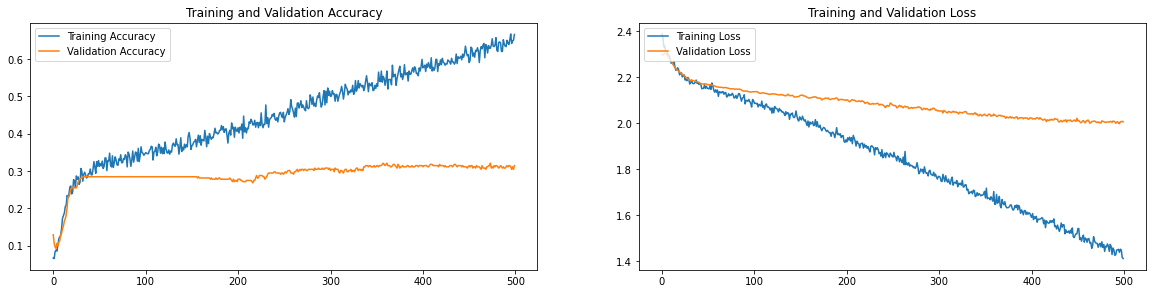

In [12]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
loss = hist.history['loss']
val_loss = hist.history['val_loss']
# print(len(acc))

epochs_range = range(500)

plt.figure(figsize=(20, 10))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='upper left')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper left')
plt.title('Training and Validation Loss')
plt.show()

#### Emotions

In [14]:
# Utility for our sequence model.
def get_sequence_model_emo():
    class_vocab = label_processor_emo.get_vocabulary()

    frame_features_input = keras.Input((MAX_SEQ_LENGTH, NUM_FEATURES))
    mask_input = keras.Input((MAX_SEQ_LENGTH,), dtype="bool")

    # Refer to the following tutorial to understand the significance of using `mask`:
    # https://keras.io/api/layers/recurrent_layers/gru/
    optimizer = keras.optimizers.Adam(learning_rate=0.00001)
    x = keras.layers.GRU(16, return_sequences=True)(
        frame_features_input, mask=mask_input
    )
    x = keras.layers.GRU(8)(x)
    x = keras.layers.Dropout(0.4)(x)
    x = keras.layers.Dense(8, activation="relu")(x)
    output = keras.layers.Dense(len(class_vocab), activation="softmax")(x)

    rnn_model = keras.Model([frame_features_input, mask_input], output)

    rnn_model.compile(
        loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"]
    )
    return rnn_model


def run_experiment_emo():
    filepath = os.path.join(os.getcwd(), 'tmp', 'video_classifier') 
    checkpoint = keras.callbacks.ModelCheckpoint(
        filepath, save_weights_only=True, save_best_only=True, verbose=1
    )

    seq_model1 = get_sequence_model_emo()
    history1 = seq_model1.fit(
        [train_data_emo[0], train_data_emo[1]],
        train_labels_emo,
        validation_split=0.3,
        epochs=EPOCHS,
        callbacks=[checkpoint],
    )

    seq_model1.load_weights(filepath)
    _, accuracy1 = seq_model1.evaluate([test_data_emo[0], test_data_emo[1]], test_labels_emo)
    print(f"Test accuracy: {round(accuracy1 * 100, 2)}%")

    return history1, seq_model1


hist_emo, sequence_model_emo = run_experiment_emo()

Epoch 1/500
21/22 [===========================>..] - ETA: 0s - loss: 1.8388 - accuracy: 0.1860
Epoch 00001: val_loss improved from inf to 1.94401, saving model to C:\Users\aritr\Documents\Project\tmp\video_classifier
22/22 [==============================] - 5s 97ms/step - loss: 1.8399 - accuracy: 0.1832 - val_loss: 1.9440 - val_accuracy: 0.0894
Epoch 2/500
21/22 [===========================>..] - ETA: 0s - loss: 1.8364 - accuracy: 0.1741
Epoch 00002: val_loss improved from 1.94401 to 1.91444, saving model to C:\Users\aritr\Documents\Project\tmp\video_classifier
22/22 [==============================] - 0s 20ms/step - loss: 1.8311 - accuracy: 0.1761 - val_loss: 1.9144 - val_accuracy: 0.0828
Epoch 3/500
21/22 [===========================>..] - ETA: 0s - loss: 1.8402 - accuracy: 0.1786
Epoch 00003: val_loss improved from 1.91444 to 1.89497, saving model to C:\Users\aritr\Documents\Project\tmp\video_classifier
22/22 [==============================] - 0s 21ms/step - loss: 1.8374 - accuracy: 

Epoch 26/500
21/22 [===========================>..] - ETA: 0s - loss: 1.7597 - accuracy: 0.2336
Epoch 00026: val_loss improved from 1.80948 to 1.80887, saving model to C:\Users\aritr\Documents\Project\tmp\video_classifier
22/22 [==============================] - 0s 21ms/step - loss: 1.7616 - accuracy: 0.2358 - val_loss: 1.8089 - val_accuracy: 0.1755
Epoch 27/500
21/22 [===========================>..] - ETA: 0s - loss: 1.7468 - accuracy: 0.2470
Epoch 00027: val_loss improved from 1.80887 to 1.80688, saving model to C:\Users\aritr\Documents\Project\tmp\video_classifier
22/22 [==============================] - 0s 21ms/step - loss: 1.7474 - accuracy: 0.2457 - val_loss: 1.8069 - val_accuracy: 0.1722
Epoch 28/500
21/22 [===========================>..] - ETA: 0s - loss: 1.7454 - accuracy: 0.2470
Epoch 00028: val_loss improved from 1.80688 to 1.80682, saving model to C:\Users\aritr\Documents\Project\tmp\video_classifier
22/22 [==============================] - 0s 21ms/step - loss: 1.7494 - acc

20/22 [==========================>...] - ETA: 0s - loss: 1.7018 - accuracy: 0.2812
Epoch 00053: val_loss did not improve from 1.79859
22/22 [==============================] - 0s 20ms/step - loss: 1.6991 - accuracy: 0.2798 - val_loss: 1.8017 - val_accuracy: 0.1921
Epoch 54/500
21/22 [===========================>..] - ETA: 0s - loss: 1.6908 - accuracy: 0.2738
Epoch 00054: val_loss did not improve from 1.79859
22/22 [==============================] - 0s 20ms/step - loss: 1.6946 - accuracy: 0.2699 - val_loss: 1.8007 - val_accuracy: 0.2020
Epoch 55/500
21/22 [===========================>..] - ETA: 0s - loss: 1.7048 - accuracy: 0.2470
Epoch 00055: val_loss improved from 1.79859 to 1.79805, saving model to C:\Users\aritr\Documents\Project\tmp\video_classifier
22/22 [==============================] - 0s 21ms/step - loss: 1.7029 - accuracy: 0.2500 - val_loss: 1.7980 - val_accuracy: 0.2086
Epoch 56/500
21/22 [===========================>..] - ETA: 0s - loss: 1.6991 - accuracy: 0.2664
Epoch 00056

Epoch 81/500
20/22 [==========================>...] - ETA: 0s - loss: 1.6498 - accuracy: 0.2906
Epoch 00081: val_loss did not improve from 1.78874
22/22 [==============================] - 0s 21ms/step - loss: 1.6513 - accuracy: 0.2969 - val_loss: 1.7890 - val_accuracy: 0.1987
Epoch 82/500
20/22 [==========================>...] - ETA: 0s - loss: 1.6467 - accuracy: 0.3125
Epoch 00082: val_loss improved from 1.78874 to 1.78643, saving model to C:\Users\aritr\Documents\Project\tmp\video_classifier
22/22 [==============================] - 0s 22ms/step - loss: 1.6435 - accuracy: 0.3068 - val_loss: 1.7864 - val_accuracy: 0.1954
Epoch 83/500
21/22 [===========================>..] - ETA: 0s - loss: 1.6480 - accuracy: 0.3140
Epoch 00083: val_loss improved from 1.78643 to 1.78524, saving model to C:\Users\aritr\Documents\Project\tmp\video_classifier
22/22 [==============================] - 0s 22ms/step - loss: 1.6468 - accuracy: 0.3139 - val_loss: 1.7852 - val_accuracy: 0.2020
Epoch 84/500
21/22 

Epoch 109/500
20/22 [==========================>...] - ETA: 0s - loss: 1.6106 - accuracy: 0.3406
Epoch 00109: val_loss improved from 1.77213 to 1.77013, saving model to C:\Users\aritr\Documents\Project\tmp\video_classifier
22/22 [==============================] - 0s 23ms/step - loss: 1.6060 - accuracy: 0.3466 - val_loss: 1.7701 - val_accuracy: 0.2119
Epoch 110/500
21/22 [===========================>..] - ETA: 0s - loss: 1.6206 - accuracy: 0.3378
Epoch 00110: val_loss did not improve from 1.77013
22/22 [==============================] - 0s 20ms/step - loss: 1.6172 - accuracy: 0.3381 - val_loss: 1.7710 - val_accuracy: 0.2219
Epoch 111/500
21/22 [===========================>..] - ETA: 0s - loss: 1.6048 - accuracy: 0.3542
Epoch 00111: val_loss did not improve from 1.77013
22/22 [==============================] - 0s 20ms/step - loss: 1.6032 - accuracy: 0.3537 - val_loss: 1.7725 - val_accuracy: 0.2219
Epoch 112/500
21/22 [===========================>..] - ETA: 0s - loss: 1.6073 - accuracy: 0

Epoch 136/500
20/22 [==========================>...] - ETA: 0s - loss: 1.5786 - accuracy: 0.3406
Epoch 00136: val_loss did not improve from 1.75647
22/22 [==============================] - 1s 23ms/step - loss: 1.5702 - accuracy: 0.3494 - val_loss: 1.7578 - val_accuracy: 0.2583
Epoch 137/500
21/22 [===========================>..] - ETA: 0s - loss: 1.5671 - accuracy: 0.3676
Epoch 00137: val_loss improved from 1.75647 to 1.75358, saving model to C:\Users\aritr\Documents\Project\tmp\video_classifier
22/22 [==============================] - 0s 21ms/step - loss: 1.5695 - accuracy: 0.3665 - val_loss: 1.7536 - val_accuracy: 0.2583
Epoch 138/500
22/22 [==============================] - ETA: 0s - loss: 1.5767 - accuracy: 0.3636
Epoch 00138: val_loss improved from 1.75358 to 1.75109, saving model to C:\Users\aritr\Documents\Project\tmp\video_classifier
22/22 [==============================] - 0s 23ms/step - loss: 1.5767 - accuracy: 0.3636 - val_loss: 1.7511 - val_accuracy: 0.2649
Epoch 139/500
20

21/22 [===========================>..] - ETA: 0s - loss: 1.5248 - accuracy: 0.3884
Epoch 00163: val_loss did not improve from 1.74198
22/22 [==============================] - 0s 19ms/step - loss: 1.5238 - accuracy: 0.3878 - val_loss: 1.7446 - val_accuracy: 0.2848
Epoch 164/500
21/22 [===========================>..] - ETA: 0s - loss: 1.5466 - accuracy: 0.3690
Epoch 00164: val_loss did not improve from 1.74198
22/22 [==============================] - 0s 20ms/step - loss: 1.5390 - accuracy: 0.3764 - val_loss: 1.7430 - val_accuracy: 0.2815
Epoch 165/500
21/22 [===========================>..] - ETA: 0s - loss: 1.5263 - accuracy: 0.4048
Epoch 00165: val_loss did not improve from 1.74198
22/22 [==============================] - 0s 20ms/step - loss: 1.5260 - accuracy: 0.4062 - val_loss: 1.7492 - val_accuracy: 0.2781
Epoch 166/500
21/22 [===========================>..] - ETA: 0s - loss: 1.5423 - accuracy: 0.3720
Epoch 00166: val_loss did not improve from 1.74198
22/22 [=========================

Epoch 191/500
21/22 [===========================>..] - ETA: 0s - loss: 1.5023 - accuracy: 0.3869
Epoch 00191: val_loss did not improve from 1.73045
22/22 [==============================] - 0s 21ms/step - loss: 1.4996 - accuracy: 0.3935 - val_loss: 1.7370 - val_accuracy: 0.2914
Epoch 192/500
21/22 [===========================>..] - ETA: 0s - loss: 1.4825 - accuracy: 0.4107
Epoch 00192: val_loss did not improve from 1.73045
22/22 [==============================] - 0s 21ms/step - loss: 1.4848 - accuracy: 0.4091 - val_loss: 1.7335 - val_accuracy: 0.2947
Epoch 193/500
21/22 [===========================>..] - ETA: 0s - loss: 1.5099 - accuracy: 0.3973
Epoch 00193: val_loss improved from 1.73045 to 1.72865, saving model to C:\Users\aritr\Documents\Project\tmp\video_classifier
22/22 [==============================] - 0s 22ms/step - loss: 1.5094 - accuracy: 0.4006 - val_loss: 1.7287 - val_accuracy: 0.3046
Epoch 194/500
21/22 [===========================>..] - ETA: 0s - loss: 1.5012 - accuracy: 0

21/22 [===========================>..] - ETA: 0s - loss: 1.4570 - accuracy: 0.4286
Epoch 00218: val_loss did not improve from 1.72140
22/22 [==============================] - 0s 21ms/step - loss: 1.4577 - accuracy: 0.4304 - val_loss: 1.7265 - val_accuracy: 0.3113
Epoch 219/500
21/22 [===========================>..] - ETA: 0s - loss: 1.4790 - accuracy: 0.3973
Epoch 00219: val_loss did not improve from 1.72140
22/22 [==============================] - 0s 21ms/step - loss: 1.4777 - accuracy: 0.3991 - val_loss: 1.7242 - val_accuracy: 0.3079
Epoch 220/500
21/22 [===========================>..] - ETA: 0s - loss: 1.4661 - accuracy: 0.4330
Epoch 00220: val_loss did not improve from 1.72140
22/22 [==============================] - 0s 21ms/step - loss: 1.4734 - accuracy: 0.4247 - val_loss: 1.7255 - val_accuracy: 0.3079
Epoch 221/500
21/22 [===========================>..] - ETA: 0s - loss: 1.4741 - accuracy: 0.4271
Epoch 00221: val_loss did not improve from 1.72140
22/22 [=========================

Epoch 246/500
21/22 [===========================>..] - ETA: 0s - loss: 1.4382 - accuracy: 0.4375
Epoch 00246: val_loss did not improve from 1.71181
22/22 [==============================] - 0s 21ms/step - loss: 1.4386 - accuracy: 0.4361 - val_loss: 1.7146 - val_accuracy: 0.3179
Epoch 247/500
21/22 [===========================>..] - ETA: 0s - loss: 1.4377 - accuracy: 0.4182
Epoch 00247: val_loss did not improve from 1.71181
22/22 [==============================] - 0s 21ms/step - loss: 1.4387 - accuracy: 0.4176 - val_loss: 1.7171 - val_accuracy: 0.3079
Epoch 248/500
21/22 [===========================>..] - ETA: 0s - loss: 1.4363 - accuracy: 0.4182
Epoch 00248: val_loss did not improve from 1.71181
22/22 [==============================] - 0s 21ms/step - loss: 1.4374 - accuracy: 0.4190 - val_loss: 1.7159 - val_accuracy: 0.3146
Epoch 249/500
21/22 [===========================>..] - ETA: 0s - loss: 1.4239 - accuracy: 0.4494
Epoch 00249: val_loss did not improve from 1.71181
22/22 [===========

Epoch 275/500
21/22 [===========================>..] - ETA: 0s - loss: 1.4092 - accuracy: 0.4643
Epoch 00275: val_loss improved from 1.70839 to 1.70789, saving model to C:\Users\aritr\Documents\Project\tmp\video_classifier
22/22 [==============================] - 0s 22ms/step - loss: 1.4169 - accuracy: 0.4545 - val_loss: 1.7079 - val_accuracy: 0.3278
Epoch 276/500
21/22 [===========================>..] - ETA: 0s - loss: 1.4087 - accuracy: 0.4568
Epoch 00276: val_loss improved from 1.70789 to 1.70739, saving model to C:\Users\aritr\Documents\Project\tmp\video_classifier
22/22 [==============================] - 0s 22ms/step - loss: 1.4002 - accuracy: 0.4631 - val_loss: 1.7074 - val_accuracy: 0.3311
Epoch 277/500
21/22 [===========================>..] - ETA: 0s - loss: 1.4095 - accuracy: 0.4688
Epoch 00277: val_loss did not improve from 1.70739
22/22 [==============================] - 0s 21ms/step - loss: 1.4092 - accuracy: 0.4730 - val_loss: 1.7107 - val_accuracy: 0.3278
Epoch 278/500
21

Epoch 304/500
21/22 [===========================>..] - ETA: 0s - loss: 1.3941 - accuracy: 0.4554
Epoch 00304: val_loss did not improve from 1.70132
22/22 [==============================] - 0s 21ms/step - loss: 1.3838 - accuracy: 0.4631 - val_loss: 1.7042 - val_accuracy: 0.3444
Epoch 305/500
21/22 [===========================>..] - ETA: 0s - loss: 1.3800 - accuracy: 0.4598
Epoch 00305: val_loss did not improve from 1.70132
22/22 [==============================] - 0s 21ms/step - loss: 1.3759 - accuracy: 0.4659 - val_loss: 1.7053 - val_accuracy: 0.3344
Epoch 306/500
20/22 [==========================>...] - ETA: 0s - loss: 1.3832 - accuracy: 0.4625
Epoch 00306: val_loss did not improve from 1.70132
22/22 [==============================] - 0s 21ms/step - loss: 1.3746 - accuracy: 0.4787 - val_loss: 1.7106 - val_accuracy: 0.3477
Epoch 307/500
22/22 [==============================] - ETA: 0s - loss: 1.3661 - accuracy: 0.4688
Epoch 00307: val_loss did not improve from 1.70132
22/22 [===========

21/22 [===========================>..] - ETA: 0s - loss: 1.3357 - accuracy: 0.4881
Epoch 00333: val_loss did not improve from 1.69938
22/22 [==============================] - 0s 21ms/step - loss: 1.3458 - accuracy: 0.4801 - val_loss: 1.7076 - val_accuracy: 0.3411
Epoch 334/500
19/22 [========================>.....] - ETA: 0s - loss: 1.3565 - accuracy: 0.4868
Epoch 00334: val_loss did not improve from 1.69938
22/22 [==============================] - 0s 21ms/step - loss: 1.3500 - accuracy: 0.4830 - val_loss: 1.7041 - val_accuracy: 0.3377
Epoch 335/500
21/22 [===========================>..] - ETA: 0s - loss: 1.3585 - accuracy: 0.4613
Epoch 00335: val_loss did not improve from 1.69938
22/22 [==============================] - 0s 21ms/step - loss: 1.3561 - accuracy: 0.4645 - val_loss: 1.7037 - val_accuracy: 0.3444
Epoch 336/500
21/22 [===========================>..] - ETA: 0s - loss: 1.3502 - accuracy: 0.4940
Epoch 00336: val_loss did not improve from 1.69938
22/22 [=========================

Epoch 363/500
22/22 [==============================] - ETA: 0s - loss: 1.3303 - accuracy: 0.4886
Epoch 00363: val_loss did not improve from 1.69938
22/22 [==============================] - 0s 23ms/step - loss: 1.3303 - accuracy: 0.4886 - val_loss: 1.7072 - val_accuracy: 0.3411
Epoch 364/500
21/22 [===========================>..] - ETA: 0s - loss: 1.3189 - accuracy: 0.4926
Epoch 00364: val_loss did not improve from 1.69938
22/22 [==============================] - 1s 24ms/step - loss: 1.3174 - accuracy: 0.4972 - val_loss: 1.7095 - val_accuracy: 0.3344
Epoch 365/500
21/22 [===========================>..] - ETA: 0s - loss: 1.3238 - accuracy: 0.5119
Epoch 00365: val_loss did not improve from 1.69938
22/22 [==============================] - 0s 22ms/step - loss: 1.3209 - accuracy: 0.5170 - val_loss: 1.7051 - val_accuracy: 0.3444
Epoch 366/500
22/22 [==============================] - ETA: 0s - loss: 1.3236 - accuracy: 0.4915
Epoch 00366: val_loss did not improve from 1.69938
22/22 [===========

Epoch 393/500
21/22 [===========================>..] - ETA: 0s - loss: 1.2893 - accuracy: 0.5104
Epoch 00393: val_loss did not improve from 1.69938
22/22 [==============================] - 0s 23ms/step - loss: 1.2866 - accuracy: 0.5142 - val_loss: 1.7142 - val_accuracy: 0.3344
Epoch 394/500
21/22 [===========================>..] - ETA: 0s - loss: 1.2946 - accuracy: 0.5357
Epoch 00394: val_loss did not improve from 1.69938
22/22 [==============================] - 0s 22ms/step - loss: 1.2970 - accuracy: 0.5284 - val_loss: 1.7097 - val_accuracy: 0.3377
Epoch 395/500
21/22 [===========================>..] - ETA: 0s - loss: 1.2929 - accuracy: 0.4911
Epoch 00395: val_loss did not improve from 1.69938
22/22 [==============================] - 0s 22ms/step - loss: 1.2924 - accuracy: 0.4872 - val_loss: 1.7115 - val_accuracy: 0.3411
Epoch 396/500
22/22 [==============================] - ETA: 0s - loss: 1.2974 - accuracy: 0.5156
Epoch 00396: val_loss did not improve from 1.69938
22/22 [===========

Epoch 423/500
21/22 [===========================>..] - ETA: 0s - loss: 1.2666 - accuracy: 0.5357
Epoch 00423: val_loss did not improve from 1.69938
22/22 [==============================] - 0s 22ms/step - loss: 1.2705 - accuracy: 0.5341 - val_loss: 1.7129 - val_accuracy: 0.3444
Epoch 424/500
20/22 [==========================>...] - ETA: 0s - loss: 1.2666 - accuracy: 0.5359
Epoch 00424: val_loss did not improve from 1.69938
22/22 [==============================] - 1s 23ms/step - loss: 1.2615 - accuracy: 0.5327 - val_loss: 1.7164 - val_accuracy: 0.3444
Epoch 425/500
22/22 [==============================] - ETA: 0s - loss: 1.2737 - accuracy: 0.5142
Epoch 00425: val_loss did not improve from 1.69938
22/22 [==============================] - 0s 23ms/step - loss: 1.2737 - accuracy: 0.5142 - val_loss: 1.7191 - val_accuracy: 0.3377
Epoch 426/500
20/22 [==========================>...] - ETA: 0s - loss: 1.2534 - accuracy: 0.5344
Epoch 00426: val_loss did not improve from 1.69938
22/22 [===========

Epoch 453/500
20/22 [==========================>...] - ETA: 0s - loss: 1.2385 - accuracy: 0.5531
Epoch 00453: val_loss did not improve from 1.69938
22/22 [==============================] - 0s 21ms/step - loss: 1.2308 - accuracy: 0.5554 - val_loss: 1.7175 - val_accuracy: 0.3411
Epoch 454/500
21/22 [===========================>..] - ETA: 0s - loss: 1.2418 - accuracy: 0.5357
Epoch 00454: val_loss did not improve from 1.69938
22/22 [==============================] - 0s 21ms/step - loss: 1.2360 - accuracy: 0.5369 - val_loss: 1.7191 - val_accuracy: 0.3411
Epoch 455/500
21/22 [===========================>..] - ETA: 0s - loss: 1.2328 - accuracy: 0.5714
Epoch 00455: val_loss did not improve from 1.69938
22/22 [==============================] - 0s 21ms/step - loss: 1.2348 - accuracy: 0.5696 - val_loss: 1.7142 - val_accuracy: 0.3411
Epoch 456/500
22/22 [==============================] - ETA: 0s - loss: 1.2487 - accuracy: 0.5128
Epoch 00456: val_loss did not improve from 1.69938
22/22 [===========

Epoch 483/500
22/22 [==============================] - ETA: 0s - loss: 1.1930 - accuracy: 0.5810
Epoch 00483: val_loss did not improve from 1.69938
22/22 [==============================] - 1s 24ms/step - loss: 1.1930 - accuracy: 0.5810 - val_loss: 1.7287 - val_accuracy: 0.3411
Epoch 484/500
22/22 [==============================] - ETA: 0s - loss: 1.2056 - accuracy: 0.5625
Epoch 00484: val_loss did not improve from 1.69938
22/22 [==============================] - 1s 24ms/step - loss: 1.2056 - accuracy: 0.5625 - val_loss: 1.7269 - val_accuracy: 0.3444
Epoch 485/500
22/22 [==============================] - ETA: 0s - loss: 1.2141 - accuracy: 0.5384
Epoch 00485: val_loss did not improve from 1.69938
22/22 [==============================] - 1s 23ms/step - loss: 1.2141 - accuracy: 0.5384 - val_loss: 1.7299 - val_accuracy: 0.3510
Epoch 486/500
22/22 [==============================] - ETA: 0s - loss: 1.2090 - accuracy: 0.5568
Epoch 00486: val_loss did not improve from 1.69938
22/22 [===========

In [15]:
y_pred_emo = []
predictions1_emo = np.argsort(sequence_model_emo.predict([test_data_emo[0], test_data_emo[1]]), axis = 1)
x=[]
for i in range(len(predictions1_emo)):
    x.append(predictions1_emo[i][[-1,-2]])
    if (test_labels_emo[i][0] == predictions1_emo[i][-1]) or (test_labels_emo[i][0] == predictions1_emo[i][-2]):
        y_pred_emo.append(test_labels_emo[i][0])
    else:
        y_pred_emo.append(predictions1_emo[i][-1])
        
print(f'Top 2 Test Accuracy: {round(metrics.accuracy_score(y_pred_emo, test_labels_emo)*100,2)}%')

Top 2 Test Accuracy: 55.78%


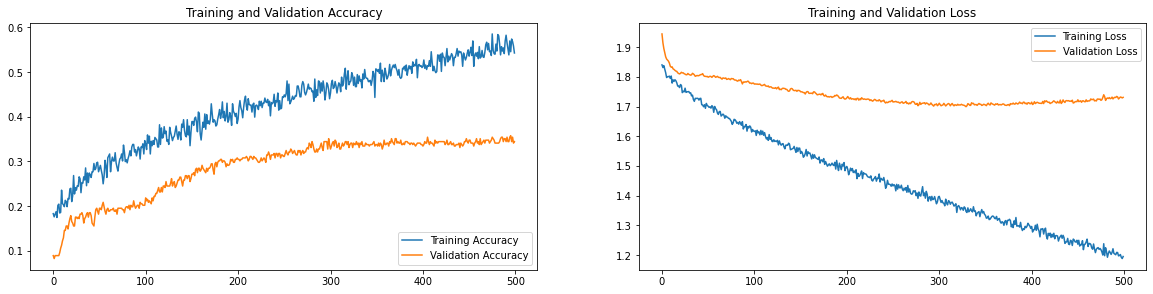

In [16]:
acc = hist_emo.history['accuracy']
val_acc = hist_emo.history['val_accuracy']
loss = hist_emo.history['loss']
val_loss = hist_emo.history['val_loss']
# print(len(acc))

epochs_range = range(500)

plt.figure(figsize=(20, 10))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Part 2: Classification after combining Image with Audio features

### Video-level MFCCs - Feature Extraction 

In [19]:
class DataSet():
    
    def __init__(self, folder):
        self.folder = folder
        self.dataset = self.get_dataset()
    
    def get_dataset(self):
        dataset = pd.read_csv(f"{os.path.join(os.getcwd(), 'Video Labels.csv')}")[['video_name', 'tag', 'train or test']]
        dataset.columns = ['path', 'label', 'train/test']    
        dataset['name'] = dataset.path
        dataset.path = dataset.path.apply(lambda x: os.path.join(folder, x))
        return dataset  
    
    def preprocess_input_resnet50(self, x):
        from keras.applications.resnet50 import preprocess_input
        X = np.expand_dims(x, axis=0)
        X = preprocess_input(X)
        return X[0]
    
    def preprocess_input_vgg16(self, x):
        from keras.applications.vgg16 import preprocess_input
        X = np.expand_dims(x, axis=0)
        X = preprocess_input(X)
        return X[0]
    
    def augment(self, src, choice):
        if choice == 0:
            # Rotate 90
            src = np.rot90(src, 1)
        if choice == 1:
            # flip vertically
            src = np.flipud(src)
        if choice == 2:
            # Rotate 180
            src = np.rot90(src, 2)
        if choice == 3:
            # flip horizontally
            src = np.fliplr(src)
        if choice == 4:
            # Rotate 90 counter-clockwise
            src = np.rot90(src, 3)
        if choice == 5:
            # Rotate 180 and flip horizontally
            src = np.rot90(src, 2)
            src = np.fliplr(src)
        if choice == 6:
            # leave it as is
            src = src
        if choice == 7:
            # shift
            src = scipy.ndimage.shift(src, 0.2)
        return src
        
    def prepare_image(self, img, size, preprocessing_function, aug=False):
        img = np.array(Image.fromarray(asarray(img)).resize(size)).astype(np.float64)
        if aug: img = self.augment(img, np.random.randint(8))
        img = preprocessing_function(img)
        return img
    
    def extract_audio(self, filepath):
        command = f"ffmpeg -i {filepath} -ab 160k -ac 2 -ar 44100 -vn {filepath.replace('mp4', 'wav')}"
        subprocess.call(command);
        
    def extract_audio_features(self, filepath, n_mfcc, return_ts=False):
        if not os.path.isfile(f"{filepath.replace('mp4', 'wav')}"): 
            self.extract_audio(filepath)
        n_mfcc = 40 if n_mfcc is None else n_mfcc
        X, sample_rate = librosa.load(f"{filepath.replace('mp4', 'wav')}", res_type='kaiser_fast')
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=n_mfcc).T,axis=0)
        if not return_ts: 
            return mfccs
        else: 
            return mfccs, X, sample_rate
    
    def get_mfccs(self, n_mfcc):
        data = self.dataset
        data['mfcc'] = data.path.apply(lambda x: self.extract_audio_features(x, n_mfcc))
        return data
            
    def process_video(self, filepath, size, preprocessing_function, aug=False):
        vid = imageio.get_reader(filepath)
        nframes = vid.get_meta_data()['nframes']
        if nframes > 100:
            nframes = 100
        l = []
        for frame in range(0, int(nframes), 3): 
            try:
                l.append(self.prepare_image(vid.get_data(frame), size, preprocessing_function, aug=aug))
            except RuntimeError:
                pass
        return l
    
    def extract_features(self, size, which_net, what, audio=False, n_mfcc=None, return_ts=False, aug=False, iterations=1):
        if which_net == 'resnet50': 
            preprocessing_function=self.preprocess_input_resnet50
            base_model = ResNet50(weights='imagenet', include_top=False)
        elif which_net == 'vgg16': 
            preprocessing_function=self.preprocess_input_vgg16
            base_model = VGG16(weights='imagenet', include_top=False)
            
        x = base_model.output
        x = GlobalAveragePooling2D()(x)
        model = Model(inputs=base_model.input, outputs=x)
        
        train = []
        valid = []
        train_i = 0
        valid_i = 0
        train_dict = {'idx': defaultdict(list), 'data': None}
        valid_dict = {'idx': defaultdict(list), 'data': None}
        flag = 1
        try:
            for path, label, tt, name in self.dataset.values:
                try:
                    for _ in range(iterations):
                        print(f'Flag: {flag}; Processing: {path}; Label: {label}')
                        flag = flag + 1
                        v = np.array(self.process_video(path, size, preprocessing_function, aug=aug))
                        frames = v.shape[0]
                        p = np.squeeze(model.predict_on_batch(v))
                        p = np.hstack((np.tile(label, frames).reshape(-1, 1), p))
                        if audio: 
                            if not return_ts:
                                mfccs = self.extract_audio_features(path, n_mfcc=n_mfcc)
                                mfccs = np.tile(mfccs, (frames, 1))
                                p = np.hstack((p, mfccs))
                            else:
                                mfccs, X, sample_rate = self.extract_audio_features(path, n_mfcc=n_mfcc, return_ts=True)
                                X = np.array_split(X, frames)
                                X = [np.random.choice(i, 100, replace=False) for i in X]
                                X = np.vstack(X)
                                p = np.hstack((p, X))                    
                        if tt == 'test':
                            valid.append(p)
                            valid_dict['idx'][name].append((valid_i, valid_i+frames))
                            valid_i+=frames
                        else:
                            train.append(p)
                            train_dict['idx'][name].append((train_i, train_i+frames))
                            train_i+=frames
                        if not aug: break
                except Exception as e:
                    print('Error:', flag)
                    continue
            flag += 1
            valid_dict['data'] = np.vstack(valid)
            train_dict['data'] = np.vstack(train)

            with open(what+'_train.pickle', 'wb') as handle:
                pickle.dump(train_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)
            with open(what+'_valid.pickle', 'wb') as handle:
                pickle.dump(valid_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)            
        
        except Exception as e:
            print('Error:', flag)
            
        return valid_dict, train_dict
    
    def map_frames_to_video(self, X, r, d):
        t_p = r.predict(X)
        l = []
        for k, v in d['idx'].items():
            l += [k]*(v[0][1]-v[0][0])

        d = pd.DataFrame({'name': l, 'frame_pred': t_p})
        d = d.groupby('name').frame_pred.mean().reset_index()
        d['video_pred'] = np.where(d.frame_pred > .5, 1, 0)
        return d

# instantiating the class
folder = f"{os.path.join(os.getcwd(), 'Video Files')}"
data = DataSet(folder)

valid_d, train_d = data.extract_features((224, 224), 'vgg16', 'frames_mfcc', audio=True, n_mfcc=100)
 
X_train, y_train = train_d['data'][:, 1:], train_d['data'][:, 0]
X_valid, y_valid = valid_d['data'][:, 1:], valid_d['data'][:, 0]

Flag: 1; Processing: C:\Users\aritr\Documents\Project\Video Files\226.mp4; Label: hiphop
Flag: 2; Processing: C:\Users\aritr\Documents\Project\Video Files\EXT_S1(0).mp4; Label: hiphop
Flag: 3; Processing: C:\Users\aritr\Documents\Project\Video Files\EXT_TEST(0)-2-of-6.mp4; Label: pop
Flag: 4; Processing: C:\Users\aritr\Documents\Project\Video Files\EXT_TEST(1)-5-of-6.mp4; Label: pop
Flag: 5; Processing: C:\Users\aritr\Documents\Project\Video Files\FINAL_DL-Ext(0).mp4; Label: pop
Flag: 6; Processing: C:\Users\aritr\Documents\Project\Video Files\MIX_TEST(0)-2-of-8.mp4; Label: pop
Flag: 7; Processing: C:\Users\aritr\Documents\Project\Video Files\MIX_TEST(1)-4-of-6.mp4; Label: pop
Flag: 8; Processing: C:\Users\aritr\Documents\Project\Video Files\MIX_TEST(5)-2-of-7.mp4; Label: hiphop
Flag: 9; Processing: C:\Users\aritr\Documents\Project\Video Files\MIX_TEST(6)-3-of-8.mp4; Label: rock
Flag: 10; Processing: C:\Users\aritr\Documents\Project\Video Files\MIX_TEST(9)-2-of-7.mp4; Label: pop
Flag: 

Flag: 81; Processing: C:\Users\aritr\Documents\Project\Video Files\TEST_FEAR(12)-5-of-7.mp4; Label: pop
Flag: 82; Processing: C:\Users\aritr\Documents\Project\Video Files\TEST_MIX(0)-2-of-9.mp4; Label: hiphop
Flag: 83; Processing: C:\Users\aritr\Documents\Project\Video Files\TEST_MIX(2)-3-of-8.mp4; Label: pop
Flag: 84; Processing: C:\Users\aritr\Documents\Project\Video Files\TEST_MIX(3)-6-of-9.mp4; Label: pop
Flag: 85; Processing: C:\Users\aritr\Documents\Project\Video Files\TEST_MIX(4)-3-of-9.mp4; Label: pop
Flag: 86; Processing: C:\Users\aritr\Documents\Project\Video Files\TEST_NTR(0)-5-of-13.mp4; Label: disco
Flag: 87; Processing: C:\Users\aritr\Documents\Project\Video Files\TEST_NTR(1)-2-of-8.mp4; Label: pop
Flag: 88; Processing: C:\Users\aritr\Documents\Project\Video Files\TEST_NTR(2)-8-of-10.mp4; Label: hiphop
Flag: 89; Processing: C:\Users\aritr\Documents\Project\Video Files\TEST_NTR(3)-2-of-8.mp4; Label: reggae
Flag: 90; Processing: C:\Users\aritr\Documents\Project\Video Files\

Flag: 161; Processing: C:\Users\aritr\Documents\Project\Video Files\TEST_RELX(33)-2-of-11.mp4; Label: classical
Flag: 162; Processing: C:\Users\aritr\Documents\Project\Video Files\TEST_RELX(35)-4-of-80.mp4; Label: reggae
Flag: 163; Processing: C:\Users\aritr\Documents\Project\Video Files\TEST_RELX(35)-64-of-80.mp4; Label: classical
Flag: 164; Processing: C:\Users\aritr\Documents\Project\Video Files\TEST_RELX(36)-2-of-7.mp4; Label: classical
Flag: 165; Processing: C:\Users\aritr\Documents\Project\Video Files\TEST_RELX(38)-9-of-10.mp4; Label: jazz
Flag: 166; Processing: C:\Users\aritr\Documents\Project\Video Files\TEST_RELX(39)-3-of-14.mp4; Label: classical
Flag: 167; Processing: C:\Users\aritr\Documents\Project\Video Files\TEST_RELX(4)-2-of-8.mp4; Label: classical
Flag: 168; Processing: C:\Users\aritr\Documents\Project\Video Files\TEST_RELX(41)-3-of-12.mp4; Label: classical
Flag: 169; Processing: C:\Users\aritr\Documents\Project\Video Files\TEST_RELX(42)-2-of-17.mp4; Label: classical
Fl

Flag: 239; Processing: C:\Users\aritr\Documents\Project\Video Files\TEST_TENS(12)-2-of-6.mp4; Label: hiphop
Flag: 240; Processing: C:\Users\aritr\Documents\Project\Video Files\TEST_TENS(15)-2-of-8.mp4; Label: hiphop
Flag: 241; Processing: C:\Users\aritr\Documents\Project\Video Files\TEST_TENS(2)-3-of-11.mp4; Label: hiphop
Flag: 242; Processing: C:\Users\aritr\Documents\Project\Video Files\TEST_TENS(23)-11-of-13.mp4; Label: pop
Flag: 243; Processing: C:\Users\aritr\Documents\Project\Video Files\TEST_TENS(25)-3-of-7.mp4; Label: hiphop
Flag: 244; Processing: C:\Users\aritr\Documents\Project\Video Files\TEST_TENS(28)-8-of-10.mp4; Label: hiphop
Flag: 245; Processing: C:\Users\aritr\Documents\Project\Video Files\TEST_TENS(3)-9-of-10.mp4; Label: hiphop
Flag: 246; Processing: C:\Users\aritr\Documents\Project\Video Files\TEST_TENS(30)-8-of-9.mp4; Label: hiphop
Flag: 247; Processing: C:\Users\aritr\Documents\Project\Video Files\TEST_TENS(32)-7-of-9.mp4; Label: metal
Flag: 248; Processing: C:\Use

Flag: 318; Processing: C:\Users\aritr\Documents\Project\Video Files\DEAP_DB_HR(12).mp4; Label: metal
Flag: 319; Processing: C:\Users\aritr\Documents\Project\Video Files\DEAP_DP_TENSMM(22).mp4; Label: metal
Flag: 320; Processing: C:\Users\aritr\Documents\Project\Video Files\FEAR_TEST(0)-6-of-15.mp4; Label: metal
Flag: 321; Processing: C:\Users\aritr\Documents\Project\Video Files\FEAR_TEST(2)-2-of-8.mp4; Label: metal
Flag: 322; Processing: C:\Users\aritr\Documents\Project\Video Files\FEAR_TEST(6)-6-of-12.mp4; Label: metal
Flag: 323; Processing: C:\Users\aritr\Documents\Project\Video Files\FEAR_TEST(8)-2-of-10.mp4; Label: metal
Flag: 324; Processing: C:\Users\aritr\Documents\Project\Video Files\FEAR_TEST(10)-7-of-12.mp4; Label: metal
Flag: 325; Processing: C:\Users\aritr\Documents\Project\Video Files\FEAR_TEST(11)-4-of-8.mp4; Label: metal
Flag: 326; Processing: C:\Users\aritr\Documents\Project\Video Files\FEAR_TEST(13)-7-of-8.mp4; Label: metal
Flag: 327; Processing: C:\Users\aritr\Documen

Flag: 397; Processing: C:\Users\aritr\Documents\Project\Video Files\DEAP_DB_EX(3).mp4; Label: pop
Flag: 398; Processing: C:\Users\aritr\Documents\Project\Video Files\DEAP_DB_EX(22).mp4; Label: reggae
Flag: 399; Processing: C:\Users\aritr\Documents\Project\Video Files\DEAP_DB_EX(23).mp4; Label: reggae
Flag: 400; Processing: C:\Users\aritr\Documents\Project\Video Files\DEAP_DB_EX(25).mp4; Label: pop
Flag: 401; Processing: C:\Users\aritr\Documents\Project\Video Files\DEAP_DB_EX(26).mp4; Label: pop
Flag: 402; Processing: C:\Users\aritr\Documents\Project\Video Files\DEAP_DB_EX(28).mp4; Label: pop
Flag: 403; Processing: C:\Users\aritr\Documents\Project\Video Files\DEAP_DB_EX(29).mp4; Label: pop
Flag: 404; Processing: C:\Users\aritr\Documents\Project\Video Files\DEAP_DB_EXTT(1).mp4; Label: pop
Flag: 405; Processing: C:\Users\aritr\Documents\Project\Video Files\DEAP_DB_EXTT(3).mp4; Label: rock
Flag: 406; Processing: C:\Users\aritr\Documents\Project\Video Files\DEAP_DB_EXTT(5).mp4; Label: hipho

Flag: 476; Processing: C:\Users\aritr\Documents\Project\Video Files\FINAL_FEAR(20).mp4; Label: rock
Flag: 477; Processing: C:\Users\aritr\Documents\Project\Video Files\LLT_DL(6)-2-of-8.mp4; Label: rock
Flag: 478; Processing: C:\Users\aritr\Documents\Project\Video Files\LLT_DL(8)-2-of-9.mp4; Label: rock
Flag: 479; Processing: C:\Users\aritr\Documents\Project\Video Files\LLT_DL(8)-5-of-9.mp4; Label: rock
Flag: 480; Processing: C:\Users\aritr\Documents\Project\Video Files\LLT_DL(9)-3-of-6.mp4; Label: rock
Flag: 481; Processing: C:\Users\aritr\Documents\Project\Video Files\LLT_DL(9)-5-of-6.mp4; Label: rock
Flag: 482; Processing: C:\Users\aritr\Documents\Project\Video Files\LLT_DL(10)-2-of-10.mp4; Label: metal
Flag: 483; Processing: C:\Users\aritr\Documents\Project\Video Files\LLT_DL(10)-4-of-10.mp4; Label: metal
Flag: 484; Processing: C:\Users\aritr\Documents\Project\Video Files\LLT_DL(10)-9-of-10.mp4; Label: metal
Flag: 485; Processing: C:\Users\aritr\Documents\Project\Video Files\LLT_DL(

Flag: 557; Processing: C:\Users\aritr\Documents\Project\Video Files\DEAP_DBW_RELX(41).mp4; Label: blues
Flag: 558; Processing: C:\Users\aritr\Documents\Project\Video Files\DEAP_DBW_RELX(42).mp4; Label: blues
Flag: 559; Processing: C:\Users\aritr\Documents\Project\Video Files\DEAP_DBW_RELX(43).mp4; Label: blues
Flag: 560; Processing: C:\Users\aritr\Documents\Project\Video Files\DEAP_DBW_RELX(45).mp4; Label: pop
Flag: 561; Processing: C:\Users\aritr\Documents\Project\Video Files\DEAP_DBW_RELX(46).mp4; Label: pop
Flag: 562; Processing: C:\Users\aritr\Documents\Project\Video Files\DEAP_DBW_RELX(48).mp4; Label: pop
Flag: 563; Processing: C:\Users\aritr\Documents\Project\Video Files\HAPPY_HEA(117)-7-of-8.mp4; Label: pop
Flag: 564; Processing: C:\Users\aritr\Documents\Project\Video Files\HAPPY_HEA(144)-2-of-4.mp4; Label: pop
Flag: 565; Processing: C:\Users\aritr\Documents\Project\Video Files\HAPPY_HEA(158)-5-of-12.mp4; Label: pop
Flag: 566; Processing: C:\Users\aritr\Documents\Project\Video F

Flag: 637; Processing: C:\Users\aritr\Documents\Project\Video Files\SAD_LLT(31)-40-of-228.mp4; Label: pop
Flag: 638; Processing: C:\Users\aritr\Documents\Project\Video Files\SAD_LLT(31)-40-of-228.mp4; Label: pop
Flag: 639; Processing: C:\Users\aritr\Documents\Project\Video Files\SAD_LLT(31)-42-of-228.mp4; Label: pop
Flag: 640; Processing: C:\Users\aritr\Documents\Project\Video Files\SAD_LLT(31)-51-of-228.mp4; Label: pop
Flag: 641; Processing: C:\Users\aritr\Documents\Project\Video Files\SAD_LLT(31)-59-of-228.mp4; Label: pop
Flag: 642; Processing: C:\Users\aritr\Documents\Project\Video Files\SAD_LLT(31)-104-of-228.mp4; Label: pop
Flag: 643; Processing: C:\Users\aritr\Documents\Project\Video Files\SAD_LLT(31)-120-of-228.mp4; Label: pop
Flag: 644; Processing: C:\Users\aritr\Documents\Project\Video Files\SAD_LLT(31)-130-of-228.mp4; Label: pop
Flag: 645; Processing: C:\Users\aritr\Documents\Project\Video Files\SAD_LLT(31)-140-of-228.mp4; Label: pop
Flag: 646; Processing: C:\Users\aritr\Docu

Flag: 717; Processing: C:\Users\aritr\Documents\Project\Video Files\193.mp4; Label: pop
Flag: 718; Processing: C:\Users\aritr\Documents\Project\Video Files\237.mp4; Label: pop
Flag: 719; Processing: C:\Users\aritr\Documents\Project\Video Files\279.mp4; Label: pop
Flag: 720; Processing: C:\Users\aritr\Documents\Project\Video Files\292.mp4; Label: pop
Flag: 721; Processing: C:\Users\aritr\Documents\Project\Video Files\Ext_FINAL_DL(1).mp4; Label: pop
Flag: 722; Processing: C:\Users\aritr\Documents\Project\Video Files\Ext_FINAL_DL(3).mp4; Label: pop
Flag: 723; Processing: C:\Users\aritr\Documents\Project\Video Files\Ext_FINAL_DL(19).mp4; Label: pop
Flag: 724; Processing: C:\Users\aritr\Documents\Project\Video Files\Ext_FINAL_DL(20).mp4; Label: pop
Flag: 725; Processing: C:\Users\aritr\Documents\Project\Video Files\Ext_FINAL_DL(22).mp4; Label: pop
Flag: 726; Processing: C:\Users\aritr\Documents\Project\Video Files\Ext_FINAL_DL(23).mp4; Label: pop
Flag: 727; Processing: C:\Users\aritr\Docume

Flag: 800; Processing: C:\Users\aritr\Documents\Project\Video Files\REVIEW_NTRL(7).mp4; Label: hiphop
Flag: 801; Processing: C:\Users\aritr\Documents\Project\Video Files\REVIEW_NTRL(8).mp4; Label: hiphop
Flag: 802; Processing: C:\Users\aritr\Documents\Project\Video Files\REVIEW_NTRL(8).mp4; Label: hiphop
Flag: 803; Processing: C:\Users\aritr\Documents\Project\Video Files\REVIEW_NTRL(11).mp4; Label: pop
Flag: 804; Processing: C:\Users\aritr\Documents\Project\Video Files\REVIEW_NTRL(12).mp4; Label: hiphop
Flag: 805; Processing: C:\Users\aritr\Documents\Project\Video Files\REVIEW_NTRL(13).mp4; Label: hiphop
Flag: 806; Processing: C:\Users\aritr\Documents\Project\Video Files\REVIEW_NTRL(14).mp4; Label: reggae
Flag: 807; Processing: C:\Users\aritr\Documents\Project\Video Files\REVIEW_NTRL(15).mp4; Label: rock
Flag: 808; Processing: C:\Users\aritr\Documents\Project\Video Files\REVIEW_NTRL(16).mp4; Label: hiphop
Flag: 809; Processing: C:\Users\aritr\Documents\Project\Video Files\REVIEW_NTRL(1

Flag: 879; Processing: C:\Users\aritr\Documents\Project\Video Files\Relx_FINAL_DL(136).mp4; Label: blues
Flag: 880; Processing: C:\Users\aritr\Documents\Project\Video Files\Relx_FINAL_DL(152).mp4; Label: classical
Flag: 881; Processing: C:\Users\aritr\Documents\Project\Video Files\Relx_FINAL_DL(154).mp4; Label: classical
Flag: 882; Processing: C:\Users\aritr\Documents\Project\Video Files\Relx_FINAL_DL(155).mp4; Label: classical
Flag: 883; Processing: C:\Users\aritr\Documents\Project\Video Files\Relx_FINAL_DL(156).mp4; Label: classical
Flag: 884; Processing: C:\Users\aritr\Documents\Project\Video Files\Relx_FINAL_DL(158).mp4; Label: classical
Flag: 885; Processing: C:\Users\aritr\Documents\Project\Video Files\Relx_FINAL_DL(159).mp4; Label: classical
Flag: 886; Processing: C:\Users\aritr\Documents\Project\Video Files\DEAP_DB_HR(42).mp4; Label: classical
Flag: 887; Processing: C:\Users\aritr\Documents\Project\Video Files\DEAP_DB_HR(43).mp4; Label: classical
Flag: 888; Processing: C:\Users

Flag: 959; Processing: C:\Users\aritr\Documents\Project\Video Files\SAD_LLT(16)-6-of-9.mp4; Label: pop
Flag: 960; Processing: C:\Users\aritr\Documents\Project\Video Files\SAD_LLT(17)-5-of-10.mp4; Label: pop
Flag: 961; Processing: C:\Users\aritr\Documents\Project\Video Files\SAD_LLT(17)-9-of-10.mp4; Label: pop
Flag: 962; Processing: C:\Users\aritr\Documents\Project\Video Files\SAD_LLT(18)-7-of-11.mp4; Label: rock
Flag: 963; Processing: C:\Users\aritr\Documents\Project\Video Files\SAD_LLT(19)-6-of-10.mp4; Label: pop
Flag: 964; Processing: C:\Users\aritr\Documents\Project\Video Files\SAD_LLT(20)-2-of-5.mp4; Label: pop
Flag: 965; Processing: C:\Users\aritr\Documents\Project\Video Files\SAD_LLT(20)-4-of-5.mp4; Label: pop
Flag: 966; Processing: C:\Users\aritr\Documents\Project\Video Files\SAD_LLT(22)-4-of-7.mp4; Label: pop
Flag: 967; Processing: C:\Users\aritr\Documents\Project\Video Files\SAD_LLT(22)-6-of-7.mp4; Label: pop
Flag: 968; Processing: C:\Users\aritr\Documents\Project\Video Files\

Flag: 1038; Processing: C:\Users\aritr\Documents\Project\Video Files\DEAP_DB_HR(23).mp4; Label: metal
Flag: 1039; Processing: C:\Users\aritr\Documents\Project\Video Files\DEAP_DB_HR(24).mp4; Label: metal
Flag: 1040; Processing: C:\Users\aritr\Documents\Project\Video Files\DEAP_DB_HR(25).mp4; Label: metal
Flag: 1041; Processing: C:\Users\aritr\Documents\Project\Video Files\DEAP_DB_HR(26).mp4; Label: metal
Flag: 1042; Processing: C:\Users\aritr\Documents\Project\Video Files\DEAP_DB_HR(27).mp4; Label: metal
Flag: 1043; Processing: C:\Users\aritr\Documents\Project\Video Files\DEAP_DB_HR(28).mp4; Label: metal
Flag: 1044; Processing: C:\Users\aritr\Documents\Project\Video Files\DEAP_DB_HR(29).mp4; Label: metal
Flag: 1045; Processing: C:\Users\aritr\Documents\Project\Video Files\DEAP_DB_HR(35).mp4; Label: metal
Flag: 1046; Processing: C:\Users\aritr\Documents\Project\Video Files\DEAP_DB_HR(36).mp4; Label: metal
Flag: 1047; Processing: C:\Users\aritr\Documents\Project\Video Files\DEAP_DB_HR(38

Flag: 1115; Processing: C:\Users\aritr\Documents\Project\Video Files\Rellx_FINAL_DL(50).mp4; Label: country
Flag: 1116; Processing: C:\Users\aritr\Documents\Project\Video Files\Rellx_FINAL_DL(52).mp4; Label: country
Flag: 1117; Processing: C:\Users\aritr\Documents\Project\Video Files\Rellx_FINAL_DL(53).mp4; Label: country
Flag: 1118; Processing: C:\Users\aritr\Documents\Project\Video Files\Rellx_FINAL_DL(55).mp4; Label: classical
Flag: 1119; Processing: C:\Users\aritr\Documents\Project\Video Files\Rellx_FINAL_DL(71).mp4; Label: classical
Flag: 1120; Processing: C:\Users\aritr\Documents\Project\Video Files\Rellx_FINAL_DL(73).mp4; Label: classical
Flag: 1121; Processing: C:\Users\aritr\Documents\Project\Video Files\Rellx_FINAL_DL(74).mp4; Label: classical
Flag: 1122; Processing: C:\Users\aritr\Documents\Project\Video Files\Rellx_FINAL_DL(105).mp4; Label: blues
Flag: 1123; Processing: C:\Users\aritr\Documents\Project\Video Files\Rellx_FINAL_DL(106).mp4; Label: classical
Flag: 1124; Proces

Flag: 1192; Processing: C:\Users\aritr\Documents\Project\Video Files\SAAD_FINAL_DL(6).mp4; Label: pop
Flag: 1193; Processing: C:\Users\aritr\Documents\Project\Video Files\SAAD_FINAL_DL(7).mp4; Label: pop
Flag: 1194; Processing: C:\Users\aritr\Documents\Project\Video Files\SAAD_FINAL_DL(8).mp4; Label: pop
Flag: 1195; Processing: C:\Users\aritr\Documents\Project\Video Files\SAAD_FINAL_DL(9).mp4; Label: pop
Flag: 1196; Processing: C:\Users\aritr\Documents\Project\Video Files\SAAD_FINAL_DL(10).mp4; Label: pop
Flag: 1197; Processing: C:\Users\aritr\Documents\Project\Video Files\Sad_FINAL_DL(25).mp4; Label: pop
Flag: 1198; Processing: C:\Users\aritr\Documents\Project\Video Files\SAD_LLT(1).mp4; Label: pop
Flag: 1199; Processing: C:\Users\aritr\Documents\Project\Video Files\SAD_LLT(2).mp4; Label: pop
Flag: 1200; Processing: C:\Users\aritr\Documents\Project\Video Files\SAD_LLT(3).mp4; Label: pop
Flag: 1201; Processing: C:\Users\aritr\Documents\Project\Video Files\SAD_LLT(4).mp4; Label: pop
Fla

### Video-level MFCCs - Classification

#### Neural Networks

In [20]:
# encode class values as integers
encoder = LabelEncoder()
encoder.fit(y_train)
encoded_y = encoder.transform(y_train)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y_train = np_utils.to_categorical(encoded_y)

# define baseline model
def baseline_model(inputs, outputs):
    # create model
    model = Sequential()
    model.add(Dense(20, input_dim=inputs, activation='relu'))
    model.add(Dense(outputs, activation='softmax'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# test results

n_inputs, n_outputs = X_train.shape[1], dummy_y_train.shape[1]
# define model
model = baseline_model(n_inputs, n_outputs)
# fit model
model.fit(X_train.astype(float), dummy_y_train, verbose=0, epochs=100)
# predict
yhat = model.predict(X_valid.astype(float))

labels = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
y_pred = []
predictions1 = np.argsort(yhat, axis = 1)
x=[]
for i in range(len(predictions1)):
    x.append(predictions1[i][[-1,-2]])
    if (y_valid[i] == labels[predictions1[i][-1]]) or (y_valid[i] == labels[predictions1[i][-2]]):
        y_pred.append(y_valid[i])
    else:
        y_pred.append(labels[predictions1[i][-1]])

print(f'Top 2 Test Accuracy: {round(metrics.accuracy_score(y_pred, y_valid)*100,2)}%')

Top 2 Test Accuracy: 63.75%


#### Random Forest

In [21]:
r = RandomForestClassifier(n_estimators=250, min_samples_leaf=25, oob_score=True, random_state=40)
r.fit(X_train, y_train)

y_pred_proba = r.predict_proba(X_valid)
y_pred = r.predict(X_valid)
labels = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
predictions1 = np.argsort(y_pred_proba, axis = 1)
x=[]
for i in range(len(predictions1)):
    x.append(predictions1[i][[-1,-2]])
    if (y_valid[i] == labels[predictions1[i][-1]]) or (y_valid[i] == labels[predictions1[i][-2]]):
        y_pred[i] = y_valid[i]
    else:
        y_pred[i] = labels[predictions1[i][-1]]

print(f'Top 2 Test Accuracy: {round(metrics.accuracy_score(y_pred, y_valid)*100,2)}%')

Top 2 Test Accuracy: 68.24%


### Frame-level Audio Signal - Feature Extraction

In [22]:
valid_d1, train_d1 = data.extract_features((224, 224), 'vgg16', 'frames_audio_trace', audio=True, n_mfcc=100, return_ts=True)
 
X_train1, y_train1 = train_d1['data'][:, 1:], train_d1['data'][:, 0]
X_valid1, y_valid1 = valid_d1['data'][:, 1:], valid_d1['data'][:, 0]

Flag: 1; Processing: C:\Users\aritr\Documents\Project\Video Files\226.mp4; Label: hiphop
Flag: 2; Processing: C:\Users\aritr\Documents\Project\Video Files\EXT_S1(0).mp4; Label: hiphop
Flag: 3; Processing: C:\Users\aritr\Documents\Project\Video Files\EXT_TEST(0)-2-of-6.mp4; Label: pop
Flag: 4; Processing: C:\Users\aritr\Documents\Project\Video Files\EXT_TEST(1)-5-of-6.mp4; Label: pop
Flag: 5; Processing: C:\Users\aritr\Documents\Project\Video Files\FINAL_DL-Ext(0).mp4; Label: pop
Flag: 6; Processing: C:\Users\aritr\Documents\Project\Video Files\MIX_TEST(0)-2-of-8.mp4; Label: pop
Flag: 7; Processing: C:\Users\aritr\Documents\Project\Video Files\MIX_TEST(1)-4-of-6.mp4; Label: pop
Flag: 8; Processing: C:\Users\aritr\Documents\Project\Video Files\MIX_TEST(5)-2-of-7.mp4; Label: hiphop
Flag: 9; Processing: C:\Users\aritr\Documents\Project\Video Files\MIX_TEST(6)-3-of-8.mp4; Label: rock
Flag: 10; Processing: C:\Users\aritr\Documents\Project\Video Files\MIX_TEST(9)-2-of-7.mp4; Label: pop
Flag: 

Flag: 81; Processing: C:\Users\aritr\Documents\Project\Video Files\TEST_FEAR(12)-5-of-7.mp4; Label: pop
Flag: 82; Processing: C:\Users\aritr\Documents\Project\Video Files\TEST_MIX(0)-2-of-9.mp4; Label: hiphop
Flag: 83; Processing: C:\Users\aritr\Documents\Project\Video Files\TEST_MIX(2)-3-of-8.mp4; Label: pop
Flag: 84; Processing: C:\Users\aritr\Documents\Project\Video Files\TEST_MIX(3)-6-of-9.mp4; Label: pop
Flag: 85; Processing: C:\Users\aritr\Documents\Project\Video Files\TEST_MIX(4)-3-of-9.mp4; Label: pop
Flag: 86; Processing: C:\Users\aritr\Documents\Project\Video Files\TEST_NTR(0)-5-of-13.mp4; Label: disco
Flag: 87; Processing: C:\Users\aritr\Documents\Project\Video Files\TEST_NTR(1)-2-of-8.mp4; Label: pop
Flag: 88; Processing: C:\Users\aritr\Documents\Project\Video Files\TEST_NTR(2)-8-of-10.mp4; Label: hiphop
Flag: 89; Processing: C:\Users\aritr\Documents\Project\Video Files\TEST_NTR(3)-2-of-8.mp4; Label: reggae
Flag: 90; Processing: C:\Users\aritr\Documents\Project\Video Files\

Flag: 161; Processing: C:\Users\aritr\Documents\Project\Video Files\TEST_RELX(33)-2-of-11.mp4; Label: classical
Flag: 162; Processing: C:\Users\aritr\Documents\Project\Video Files\TEST_RELX(35)-4-of-80.mp4; Label: reggae
Flag: 163; Processing: C:\Users\aritr\Documents\Project\Video Files\TEST_RELX(35)-64-of-80.mp4; Label: classical
Flag: 164; Processing: C:\Users\aritr\Documents\Project\Video Files\TEST_RELX(36)-2-of-7.mp4; Label: classical
Flag: 165; Processing: C:\Users\aritr\Documents\Project\Video Files\TEST_RELX(38)-9-of-10.mp4; Label: jazz
Flag: 166; Processing: C:\Users\aritr\Documents\Project\Video Files\TEST_RELX(39)-3-of-14.mp4; Label: classical
Flag: 167; Processing: C:\Users\aritr\Documents\Project\Video Files\TEST_RELX(4)-2-of-8.mp4; Label: classical
Flag: 168; Processing: C:\Users\aritr\Documents\Project\Video Files\TEST_RELX(41)-3-of-12.mp4; Label: classical
Flag: 169; Processing: C:\Users\aritr\Documents\Project\Video Files\TEST_RELX(42)-2-of-17.mp4; Label: classical
Fl

Flag: 239; Processing: C:\Users\aritr\Documents\Project\Video Files\TEST_TENS(12)-2-of-6.mp4; Label: hiphop
Flag: 240; Processing: C:\Users\aritr\Documents\Project\Video Files\TEST_TENS(15)-2-of-8.mp4; Label: hiphop
Flag: 241; Processing: C:\Users\aritr\Documents\Project\Video Files\TEST_TENS(2)-3-of-11.mp4; Label: hiphop
Flag: 242; Processing: C:\Users\aritr\Documents\Project\Video Files\TEST_TENS(23)-11-of-13.mp4; Label: pop
Flag: 243; Processing: C:\Users\aritr\Documents\Project\Video Files\TEST_TENS(25)-3-of-7.mp4; Label: hiphop
Flag: 244; Processing: C:\Users\aritr\Documents\Project\Video Files\TEST_TENS(28)-8-of-10.mp4; Label: hiphop
Flag: 245; Processing: C:\Users\aritr\Documents\Project\Video Files\TEST_TENS(3)-9-of-10.mp4; Label: hiphop
Flag: 246; Processing: C:\Users\aritr\Documents\Project\Video Files\TEST_TENS(30)-8-of-9.mp4; Label: hiphop
Flag: 247; Processing: C:\Users\aritr\Documents\Project\Video Files\TEST_TENS(32)-7-of-9.mp4; Label: metal
Flag: 248; Processing: C:\Use

Flag: 318; Processing: C:\Users\aritr\Documents\Project\Video Files\DEAP_DB_HR(12).mp4; Label: metal
Flag: 319; Processing: C:\Users\aritr\Documents\Project\Video Files\DEAP_DP_TENSMM(22).mp4; Label: metal
Flag: 320; Processing: C:\Users\aritr\Documents\Project\Video Files\FEAR_TEST(0)-6-of-15.mp4; Label: metal
Flag: 321; Processing: C:\Users\aritr\Documents\Project\Video Files\FEAR_TEST(2)-2-of-8.mp4; Label: metal
Flag: 322; Processing: C:\Users\aritr\Documents\Project\Video Files\FEAR_TEST(6)-6-of-12.mp4; Label: metal
Flag: 323; Processing: C:\Users\aritr\Documents\Project\Video Files\FEAR_TEST(8)-2-of-10.mp4; Label: metal
Flag: 324; Processing: C:\Users\aritr\Documents\Project\Video Files\FEAR_TEST(10)-7-of-12.mp4; Label: metal
Flag: 325; Processing: C:\Users\aritr\Documents\Project\Video Files\FEAR_TEST(11)-4-of-8.mp4; Label: metal
Flag: 326; Processing: C:\Users\aritr\Documents\Project\Video Files\FEAR_TEST(13)-7-of-8.mp4; Label: metal
Flag: 327; Processing: C:\Users\aritr\Documen

Flag: 397; Processing: C:\Users\aritr\Documents\Project\Video Files\DEAP_DB_EX(3).mp4; Label: pop
Flag: 398; Processing: C:\Users\aritr\Documents\Project\Video Files\DEAP_DB_EX(22).mp4; Label: reggae
Flag: 399; Processing: C:\Users\aritr\Documents\Project\Video Files\DEAP_DB_EX(23).mp4; Label: reggae
Flag: 400; Processing: C:\Users\aritr\Documents\Project\Video Files\DEAP_DB_EX(25).mp4; Label: pop
Flag: 401; Processing: C:\Users\aritr\Documents\Project\Video Files\DEAP_DB_EX(26).mp4; Label: pop
Flag: 402; Processing: C:\Users\aritr\Documents\Project\Video Files\DEAP_DB_EX(28).mp4; Label: pop
Flag: 403; Processing: C:\Users\aritr\Documents\Project\Video Files\DEAP_DB_EX(29).mp4; Label: pop
Flag: 404; Processing: C:\Users\aritr\Documents\Project\Video Files\DEAP_DB_EXTT(1).mp4; Label: pop
Flag: 405; Processing: C:\Users\aritr\Documents\Project\Video Files\DEAP_DB_EXTT(3).mp4; Label: rock
Flag: 406; Processing: C:\Users\aritr\Documents\Project\Video Files\DEAP_DB_EXTT(5).mp4; Label: hipho

Flag: 476; Processing: C:\Users\aritr\Documents\Project\Video Files\FINAL_FEAR(20).mp4; Label: rock
Flag: 477; Processing: C:\Users\aritr\Documents\Project\Video Files\LLT_DL(6)-2-of-8.mp4; Label: rock
Flag: 478; Processing: C:\Users\aritr\Documents\Project\Video Files\LLT_DL(8)-2-of-9.mp4; Label: rock
Flag: 479; Processing: C:\Users\aritr\Documents\Project\Video Files\LLT_DL(8)-5-of-9.mp4; Label: rock
Flag: 480; Processing: C:\Users\aritr\Documents\Project\Video Files\LLT_DL(9)-3-of-6.mp4; Label: rock
Flag: 481; Processing: C:\Users\aritr\Documents\Project\Video Files\LLT_DL(9)-5-of-6.mp4; Label: rock
Flag: 482; Processing: C:\Users\aritr\Documents\Project\Video Files\LLT_DL(10)-2-of-10.mp4; Label: metal
Flag: 483; Processing: C:\Users\aritr\Documents\Project\Video Files\LLT_DL(10)-4-of-10.mp4; Label: metal
Flag: 484; Processing: C:\Users\aritr\Documents\Project\Video Files\LLT_DL(10)-9-of-10.mp4; Label: metal
Flag: 485; Processing: C:\Users\aritr\Documents\Project\Video Files\LLT_DL(

Flag: 557; Processing: C:\Users\aritr\Documents\Project\Video Files\DEAP_DBW_RELX(41).mp4; Label: blues
Flag: 558; Processing: C:\Users\aritr\Documents\Project\Video Files\DEAP_DBW_RELX(42).mp4; Label: blues
Flag: 559; Processing: C:\Users\aritr\Documents\Project\Video Files\DEAP_DBW_RELX(43).mp4; Label: blues
Flag: 560; Processing: C:\Users\aritr\Documents\Project\Video Files\DEAP_DBW_RELX(45).mp4; Label: pop
Flag: 561; Processing: C:\Users\aritr\Documents\Project\Video Files\DEAP_DBW_RELX(46).mp4; Label: pop
Flag: 562; Processing: C:\Users\aritr\Documents\Project\Video Files\DEAP_DBW_RELX(48).mp4; Label: pop
Flag: 563; Processing: C:\Users\aritr\Documents\Project\Video Files\HAPPY_HEA(117)-7-of-8.mp4; Label: pop
Flag: 564; Processing: C:\Users\aritr\Documents\Project\Video Files\HAPPY_HEA(144)-2-of-4.mp4; Label: pop
Flag: 565; Processing: C:\Users\aritr\Documents\Project\Video Files\HAPPY_HEA(158)-5-of-12.mp4; Label: pop
Flag: 566; Processing: C:\Users\aritr\Documents\Project\Video F

Flag: 637; Processing: C:\Users\aritr\Documents\Project\Video Files\SAD_LLT(31)-40-of-228.mp4; Label: pop
Flag: 638; Processing: C:\Users\aritr\Documents\Project\Video Files\SAD_LLT(31)-40-of-228.mp4; Label: pop
Flag: 639; Processing: C:\Users\aritr\Documents\Project\Video Files\SAD_LLT(31)-42-of-228.mp4; Label: pop
Flag: 640; Processing: C:\Users\aritr\Documents\Project\Video Files\SAD_LLT(31)-51-of-228.mp4; Label: pop
Flag: 641; Processing: C:\Users\aritr\Documents\Project\Video Files\SAD_LLT(31)-59-of-228.mp4; Label: pop
Flag: 642; Processing: C:\Users\aritr\Documents\Project\Video Files\SAD_LLT(31)-104-of-228.mp4; Label: pop
Flag: 643; Processing: C:\Users\aritr\Documents\Project\Video Files\SAD_LLT(31)-120-of-228.mp4; Label: pop
Flag: 644; Processing: C:\Users\aritr\Documents\Project\Video Files\SAD_LLT(31)-130-of-228.mp4; Label: pop
Flag: 645; Processing: C:\Users\aritr\Documents\Project\Video Files\SAD_LLT(31)-140-of-228.mp4; Label: pop
Flag: 646; Processing: C:\Users\aritr\Docu

Flag: 717; Processing: C:\Users\aritr\Documents\Project\Video Files\193.mp4; Label: pop
Flag: 718; Processing: C:\Users\aritr\Documents\Project\Video Files\237.mp4; Label: pop
Flag: 719; Processing: C:\Users\aritr\Documents\Project\Video Files\279.mp4; Label: pop
Flag: 720; Processing: C:\Users\aritr\Documents\Project\Video Files\292.mp4; Label: pop
Flag: 721; Processing: C:\Users\aritr\Documents\Project\Video Files\Ext_FINAL_DL(1).mp4; Label: pop
Flag: 722; Processing: C:\Users\aritr\Documents\Project\Video Files\Ext_FINAL_DL(3).mp4; Label: pop
Flag: 723; Processing: C:\Users\aritr\Documents\Project\Video Files\Ext_FINAL_DL(19).mp4; Label: pop
Flag: 724; Processing: C:\Users\aritr\Documents\Project\Video Files\Ext_FINAL_DL(20).mp4; Label: pop
Flag: 725; Processing: C:\Users\aritr\Documents\Project\Video Files\Ext_FINAL_DL(22).mp4; Label: pop
Flag: 726; Processing: C:\Users\aritr\Documents\Project\Video Files\Ext_FINAL_DL(23).mp4; Label: pop
Flag: 727; Processing: C:\Users\aritr\Docume

Flag: 800; Processing: C:\Users\aritr\Documents\Project\Video Files\REVIEW_NTRL(7).mp4; Label: hiphop
Flag: 801; Processing: C:\Users\aritr\Documents\Project\Video Files\REVIEW_NTRL(8).mp4; Label: hiphop
Flag: 802; Processing: C:\Users\aritr\Documents\Project\Video Files\REVIEW_NTRL(8).mp4; Label: hiphop
Flag: 803; Processing: C:\Users\aritr\Documents\Project\Video Files\REVIEW_NTRL(11).mp4; Label: pop
Flag: 804; Processing: C:\Users\aritr\Documents\Project\Video Files\REVIEW_NTRL(12).mp4; Label: hiphop
Flag: 805; Processing: C:\Users\aritr\Documents\Project\Video Files\REVIEW_NTRL(13).mp4; Label: hiphop
Flag: 806; Processing: C:\Users\aritr\Documents\Project\Video Files\REVIEW_NTRL(14).mp4; Label: reggae
Flag: 807; Processing: C:\Users\aritr\Documents\Project\Video Files\REVIEW_NTRL(15).mp4; Label: rock
Flag: 808; Processing: C:\Users\aritr\Documents\Project\Video Files\REVIEW_NTRL(16).mp4; Label: hiphop
Flag: 809; Processing: C:\Users\aritr\Documents\Project\Video Files\REVIEW_NTRL(1

Flag: 879; Processing: C:\Users\aritr\Documents\Project\Video Files\Relx_FINAL_DL(136).mp4; Label: blues
Flag: 880; Processing: C:\Users\aritr\Documents\Project\Video Files\Relx_FINAL_DL(152).mp4; Label: classical
Flag: 881; Processing: C:\Users\aritr\Documents\Project\Video Files\Relx_FINAL_DL(154).mp4; Label: classical
Flag: 882; Processing: C:\Users\aritr\Documents\Project\Video Files\Relx_FINAL_DL(155).mp4; Label: classical
Flag: 883; Processing: C:\Users\aritr\Documents\Project\Video Files\Relx_FINAL_DL(156).mp4; Label: classical
Flag: 884; Processing: C:\Users\aritr\Documents\Project\Video Files\Relx_FINAL_DL(158).mp4; Label: classical
Flag: 885; Processing: C:\Users\aritr\Documents\Project\Video Files\Relx_FINAL_DL(159).mp4; Label: classical
Flag: 886; Processing: C:\Users\aritr\Documents\Project\Video Files\DEAP_DB_HR(42).mp4; Label: classical
Flag: 887; Processing: C:\Users\aritr\Documents\Project\Video Files\DEAP_DB_HR(43).mp4; Label: classical
Flag: 888; Processing: C:\Users

Flag: 959; Processing: C:\Users\aritr\Documents\Project\Video Files\SAD_LLT(16)-6-of-9.mp4; Label: pop
Flag: 960; Processing: C:\Users\aritr\Documents\Project\Video Files\SAD_LLT(17)-5-of-10.mp4; Label: pop
Flag: 961; Processing: C:\Users\aritr\Documents\Project\Video Files\SAD_LLT(17)-9-of-10.mp4; Label: pop
Flag: 962; Processing: C:\Users\aritr\Documents\Project\Video Files\SAD_LLT(18)-7-of-11.mp4; Label: rock
Flag: 963; Processing: C:\Users\aritr\Documents\Project\Video Files\SAD_LLT(19)-6-of-10.mp4; Label: pop
Flag: 964; Processing: C:\Users\aritr\Documents\Project\Video Files\SAD_LLT(20)-2-of-5.mp4; Label: pop
Flag: 965; Processing: C:\Users\aritr\Documents\Project\Video Files\SAD_LLT(20)-4-of-5.mp4; Label: pop
Flag: 966; Processing: C:\Users\aritr\Documents\Project\Video Files\SAD_LLT(22)-4-of-7.mp4; Label: pop
Flag: 967; Processing: C:\Users\aritr\Documents\Project\Video Files\SAD_LLT(22)-6-of-7.mp4; Label: pop
Flag: 968; Processing: C:\Users\aritr\Documents\Project\Video Files\

Flag: 1038; Processing: C:\Users\aritr\Documents\Project\Video Files\DEAP_DB_HR(23).mp4; Label: metal
Flag: 1039; Processing: C:\Users\aritr\Documents\Project\Video Files\DEAP_DB_HR(24).mp4; Label: metal
Flag: 1040; Processing: C:\Users\aritr\Documents\Project\Video Files\DEAP_DB_HR(25).mp4; Label: metal
Flag: 1041; Processing: C:\Users\aritr\Documents\Project\Video Files\DEAP_DB_HR(26).mp4; Label: metal
Flag: 1042; Processing: C:\Users\aritr\Documents\Project\Video Files\DEAP_DB_HR(27).mp4; Label: metal
Flag: 1043; Processing: C:\Users\aritr\Documents\Project\Video Files\DEAP_DB_HR(28).mp4; Label: metal
Flag: 1044; Processing: C:\Users\aritr\Documents\Project\Video Files\DEAP_DB_HR(29).mp4; Label: metal
Flag: 1045; Processing: C:\Users\aritr\Documents\Project\Video Files\DEAP_DB_HR(35).mp4; Label: metal
Flag: 1046; Processing: C:\Users\aritr\Documents\Project\Video Files\DEAP_DB_HR(36).mp4; Label: metal
Flag: 1047; Processing: C:\Users\aritr\Documents\Project\Video Files\DEAP_DB_HR(38

Flag: 1115; Processing: C:\Users\aritr\Documents\Project\Video Files\Rellx_FINAL_DL(50).mp4; Label: country
Flag: 1116; Processing: C:\Users\aritr\Documents\Project\Video Files\Rellx_FINAL_DL(52).mp4; Label: country
Flag: 1117; Processing: C:\Users\aritr\Documents\Project\Video Files\Rellx_FINAL_DL(53).mp4; Label: country
Flag: 1118; Processing: C:\Users\aritr\Documents\Project\Video Files\Rellx_FINAL_DL(55).mp4; Label: classical
Flag: 1119; Processing: C:\Users\aritr\Documents\Project\Video Files\Rellx_FINAL_DL(71).mp4; Label: classical
Flag: 1120; Processing: C:\Users\aritr\Documents\Project\Video Files\Rellx_FINAL_DL(73).mp4; Label: classical
Flag: 1121; Processing: C:\Users\aritr\Documents\Project\Video Files\Rellx_FINAL_DL(74).mp4; Label: classical
Flag: 1122; Processing: C:\Users\aritr\Documents\Project\Video Files\Rellx_FINAL_DL(105).mp4; Label: blues
Flag: 1123; Processing: C:\Users\aritr\Documents\Project\Video Files\Rellx_FINAL_DL(106).mp4; Label: classical
Flag: 1124; Proces

Flag: 1192; Processing: C:\Users\aritr\Documents\Project\Video Files\SAAD_FINAL_DL(6).mp4; Label: pop
Flag: 1193; Processing: C:\Users\aritr\Documents\Project\Video Files\SAAD_FINAL_DL(7).mp4; Label: pop
Flag: 1194; Processing: C:\Users\aritr\Documents\Project\Video Files\SAAD_FINAL_DL(8).mp4; Label: pop
Flag: 1195; Processing: C:\Users\aritr\Documents\Project\Video Files\SAAD_FINAL_DL(9).mp4; Label: pop
Flag: 1196; Processing: C:\Users\aritr\Documents\Project\Video Files\SAAD_FINAL_DL(10).mp4; Label: pop
Flag: 1197; Processing: C:\Users\aritr\Documents\Project\Video Files\Sad_FINAL_DL(25).mp4; Label: pop
Flag: 1198; Processing: C:\Users\aritr\Documents\Project\Video Files\SAD_LLT(1).mp4; Label: pop
Flag: 1199; Processing: C:\Users\aritr\Documents\Project\Video Files\SAD_LLT(2).mp4; Label: pop
Flag: 1200; Processing: C:\Users\aritr\Documents\Project\Video Files\SAD_LLT(3).mp4; Label: pop
Flag: 1201; Processing: C:\Users\aritr\Documents\Project\Video Files\SAD_LLT(4).mp4; Label: pop
Fla

### Frame-level Audio Signal - Classification

#### Neural Networks

In [25]:
# encode class values as integers
encoder = LabelEncoder()
encoder.fit(y_train1)
encoded_y = encoder.transform(y_train1)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y_train1 = np_utils.to_categorical(encoded_y)

# define baseline model
def baseline_model(inputs, outputs):
    # create model
    model = Sequential()
    model.add(Dense(20, input_dim=inputs, activation='relu'))
    model.add(Dense(outputs, activation='softmax'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# test results

n_inputs, n_outputs = X_train1.shape[1], dummy_y_train1.shape[1]
# define model
model = baseline_model(n_inputs, n_outputs)
# fit model
model.fit(X_train1.astype(float), dummy_y_train1, verbose=0, epochs=100)
# predict
yhat = model.predict(X_valid1.astype(float))

labels = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
y_pred = []
predictions1 = np.argsort(yhat, axis = 1)
x=[]
for i in range(len(predictions1)):
    x.append(predictions1[i][[-1,-2]])
    if (y_valid1[i] == labels[predictions1[i][-1]]) or (y_valid1[i] == labels[predictions1[i][-2]]):
        y_pred.append(y_valid1[i])
    else:
        y_pred.append(labels[predictions1[i][-1]])

print(f'Top 2 Test Accuracy: {round(metrics.accuracy_score(y_pred, y_valid1)*100,2)}%')

Top 2 Test Accuracy: 44.77%


#### Random Forest

In [26]:
r = RandomForestClassifier(n_estimators=150, min_samples_leaf=19, oob_score=True, random_state=40)
r.fit(X_train1, y_train1)

y_pred_proba = r.predict_proba(X_valid1)
y_pred = r.predict(X_valid1)
labels = ['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
predictions1 = np.argsort(y_pred_proba, axis = 1)
x=[]
for i in range(len(predictions1)):
    x.append(predictions1[i][[-1,-2]])
    if (y_valid1[i] == labels[predictions1[i][-1]]) or (y_valid1[i] == labels[predictions1[i][-2]]):
        y_pred[i] = y_valid1[i]
    else:
        y_pred[i] = labels[predictions1[i][-1]]
        
print(f'Top 2 Test Accuracy: {round(metrics.accuracy_score(y_pred, y_valid1)*100,2)}%')

Top 2 Test Accuracy: 52.92%
